# Libraries import

In [ ]:
!pip install scikeras

In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# Mount

In [ ]:
drive.mount('/content/drive', force_remount=True)
source_folder = '/content/drive/MyDrive/Dataset_HW_ML'

for dir in os.listdir(source_folder):
  dir_path = os.path.join(source_folder, dir)
  if os.path.isdir(dir_path):
    print(f"Directory: {dir}")
    for file in os.listdir(dir_path):
      print(f"\tFile: {file}")

Mounted at /content/drive
Directory: R3
	File: r3_333_100k.csv
	File: r3_666_100k.csv
	File: r3_999_100k.csv
Directory: R5
	File: r5_333_100k.csv
	File: r5_666_100k.csv
	File: r5_999_100k.csv
Directory: R2
	File: r2_333_100k.csv
	File: r2_666_100k.csv
	File: r2_999_100k.csv


# Dataset Creation

In [ ]:
def load_and_trim_data(data_path, dim_data):
    """Load dataset from a file and trim to the specified number of rows."""
    df = pd.read_csv(data_path, sep=';')
    return df.iloc[:dim_data]

def assign_column_names(df, columns):
    """Assign specified column names to the dataframe."""
    df.columns = columns
    return df

def split_features_and_targets(df, feature_columns, target_columns):
    """Split the dataframe into features and targets."""
    features = df[feature_columns].values
    targets = df[target_columns].values
    return features, targets

def split_train_val_test(features, targets, test_size, scale):
    """
    Split features and targets into training, validation, and test sets,
    and scale them if required.
    """
    # Train + validation split
    X_train, X_val, y_train, y_val = train_test_split(
        features, targets, test_size=test_size, random_state=42
    )

    # Test set split
    tmp_x, X_test, tmp_y, y_test = train_test_split(
        features, targets, test_size=test_size, random_state=42
    )

    if scale:
        scaler_train = StandardScaler()
        X_train_scaled = scaler_train.fit_transform(X_train)
        X_val_scaled = scaler_train.transform(X_val)

        scaler_test = StandardScaler()
        scaler_test.fit(tmp_x)
        X_test_scaled = scaler_test.transform(X_test)
    else:
        X_train_scaled = X_train
        X_val_scaled = X_val
        X_test_scaled = X_test

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def create_dataset(data_path_train, data_path_test, dim_data, test_size, scale, feature_columns, target_columns, column_names):
    """Function to load, preprocess, and split a dataset."""
    # Load and preprocess data
    df_train_val = load_and_trim_data(data_path_train, dim_data)
    df_test = load_and_trim_data(data_path_test, dim_data)

    # Assign column names
    df_train_val = assign_column_names(df_train_val, column_names)
    df_test = assign_column_names(df_test, column_names)

    # Split features and targets
    features, targets = split_features_and_targets(df_train_val, feature_columns, target_columns)

    # Split and scale data
    return split_train_val_test(features, targets, test_size, scale)

def create_dataset_R2(data_path_train, data_path_test, dim_data, test_size, scale):
    columns = ['j0', 'j1', 'cos(j0)', 'cos(j1)', 'sin(j0)', 'sin(j1)', 'ft_x', 'ft_y', 'ft_qw', 'ft_qz']
    feature_columns = ['j0', 'j1']
    target_columns = ['ft_x', 'ft_y', 'ft_qw', 'ft_qz']
    return create_dataset(data_path_train, data_path_test, dim_data, test_size, scale, feature_columns, target_columns, columns)

def create_dataset_R3(data_path_train, data_path_test, dim_data, test_size, scale):
    columns = ['j0', 'j1', 'j2', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'sin(j0)', 'sin(j1)', 'sin(j2)', 'ft_x', 'ft_y', 'ft_qw', 'ft_qz']
    feature_columns = ['j0', 'j1', 'j2']
    target_columns = ['ft_x', 'ft_y', 'ft_qw', 'ft_qz']
    return create_dataset(data_path_train, data_path_test, dim_data, test_size, scale, feature_columns, target_columns, columns)

def create_dataset_R5(data_path_train, data_path_test, dim_data, test_size, scale):
    columns = ['j0', 'j1', 'j2', 'j3', 'j4', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'cos(j3)', 'cos(j4)',
               'sin(j0)', 'sin(j1)', 'sin(j2)', 'sin(j3)', 'sin(j4)',
               'ft_x', 'ft_y', 'ft_z', 'ft_qw', 'ft_qx', 'ft_qy', 'ft_qz']
    feature_columns = ['j0', 'j1', 'j2', 'j3', 'j4']
    target_columns = ['ft_x', 'ft_y', 'ft_z', 'ft_qw', 'ft_qx', 'ft_qy', 'ft_qz']
    return create_dataset(data_path_train, data_path_test, dim_data, test_size, scale, feature_columns, target_columns, columns)

#R2

##Dataset exploration

In [ ]:
current_dir = "/content/drive/MyDrive/Dataset_HW_ML/R2"
for file in os.listdir(current_dir):
      file_path = os.path.join(current_dir, file)

data_path_train = "/content/drive/MyDrive/Dataset_HW_ML/R2/r2_333_100k.csv"
data_path_test  = "/content/drive/MyDrive/Dataset_HW_ML/R2/r2_666_100k.csv"

df_train_DA = pd.read_csv(data_path_train, sep=';')
df_train_DA.columns = ['j0', 'j1', 'cos(j0)', 'cos(j1)', 'sin(j0)', 'sin(j1)', 'ft_x', 'ft_y', 'ft_qw', 'ft_qz']

df_test_DA = pd.read_csv(data_path_test, sep=';')
df_test_DA.columns = ['j0', 'j1', 'cos(j0)', 'cos(j1)', 'sin(j0)', 'sin(j1)', 'ft_x', 'ft_y', 'ft_qw', 'ft_qz']

df_1k_train_DA = df_train_DA.copy().iloc[:1000]
df_1k_test_DA = df_test_DA.copy().iloc[:1000]

seed_train = "333"
seed_test = "666"

df_train_DA.head()

j0     j1  cos(j0)  cos(j1)  sin(j0)  sin(j1)   ft_x   ft_y  ft_qw  \
0  0.084  0.066    0.996    0.998    0.084    0.066  0.208  0.025  0.997   
1  0.117  0.093    0.993    0.996    0.117    0.093  0.207  0.035  0.995   
2  0.187  0.169    0.983    0.986    0.186    0.168  0.201  0.057  0.984   
3  0.297  0.277    0.956    0.962    0.293    0.274  0.188  0.089  0.959   
4  0.466  0.400    0.894    0.921    0.449    0.389  0.161  0.129  0.908   

   ft_qz  
0  0.075  
1  0.105  
2  0.177  
3  0.283  
4  0.419

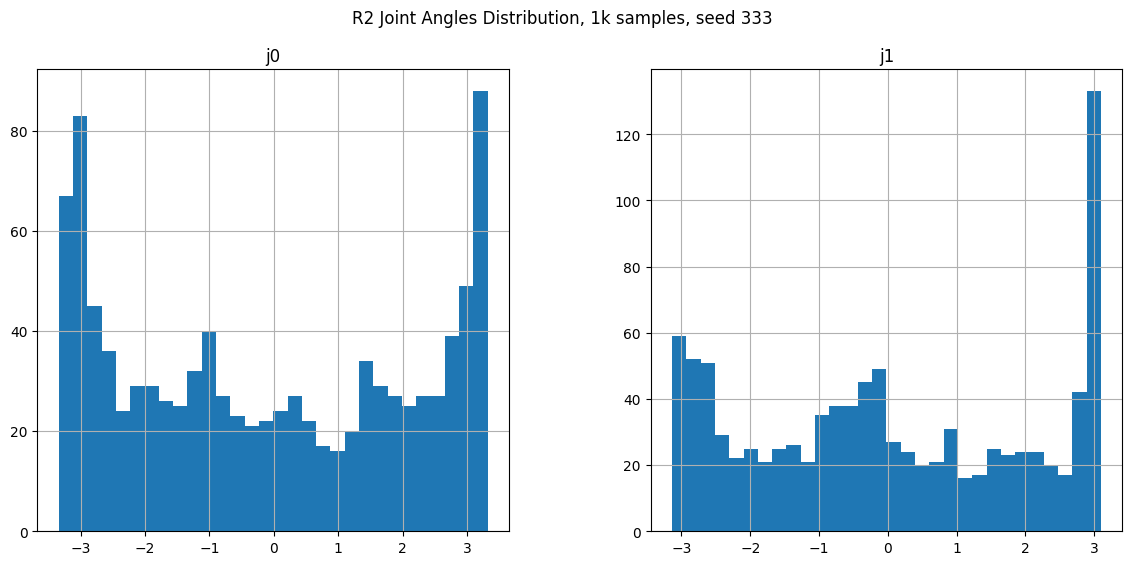

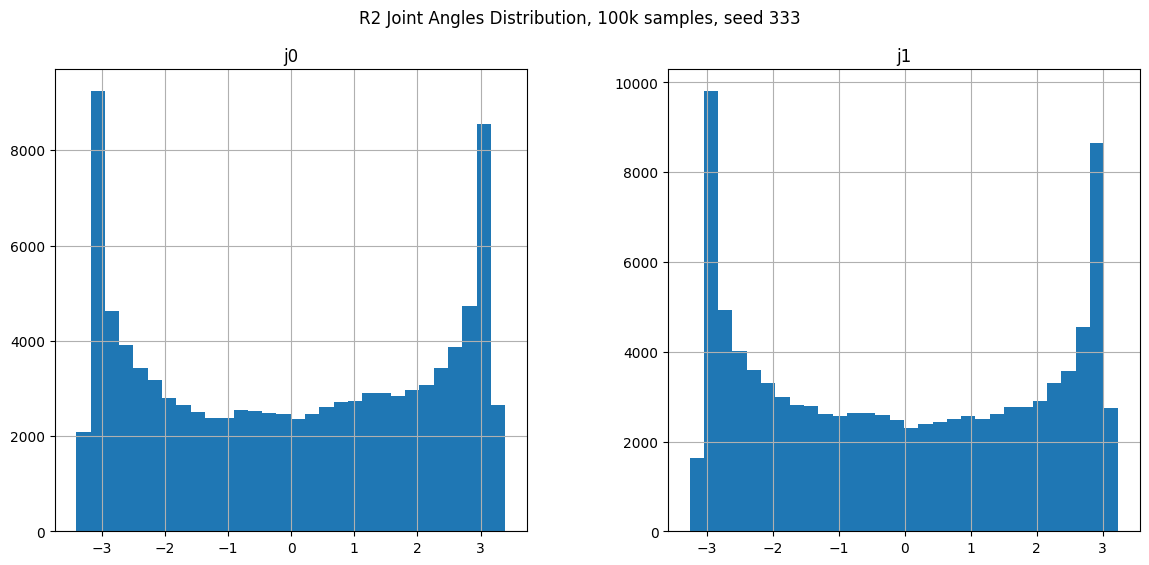

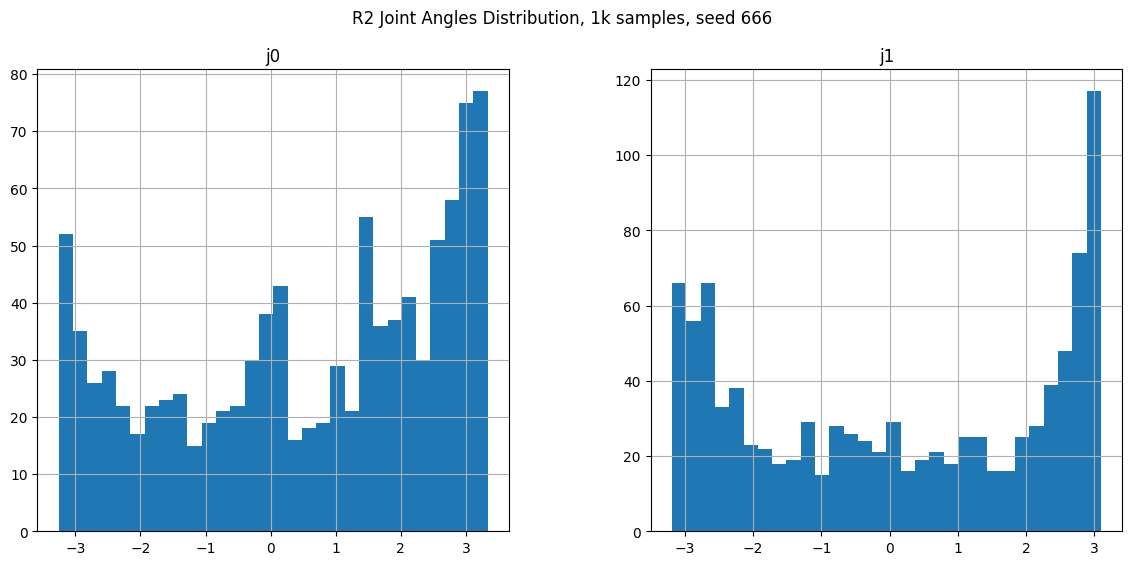

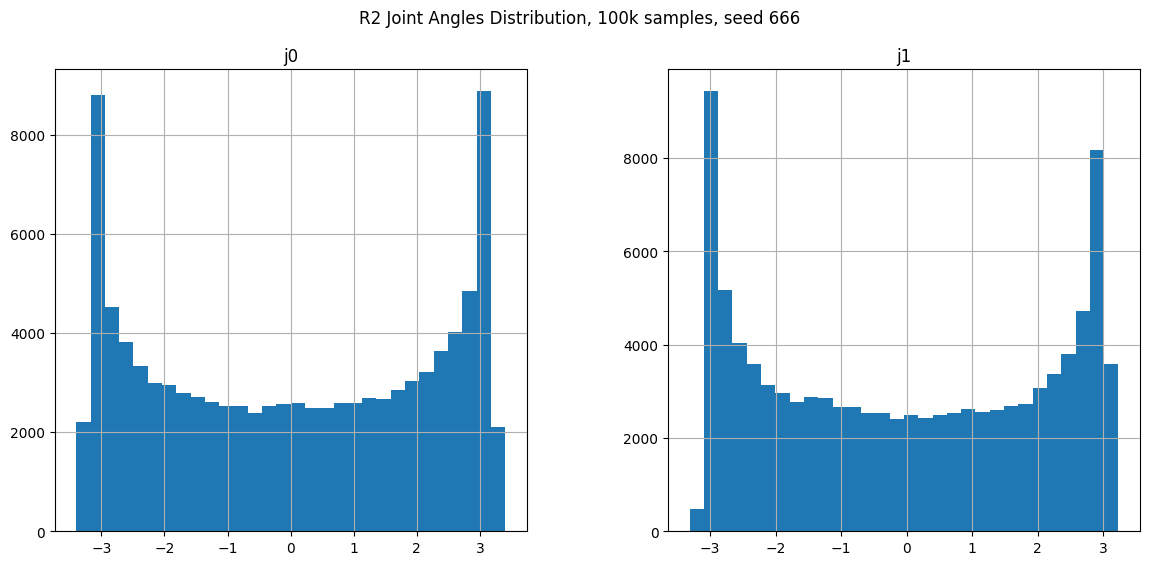

In [ ]:
def hist_plot_R2(df, strg, seed):
  df[['j0', 'j1']].hist(bins=30, figsize=(14, 6))
  plt.suptitle('R2 Joint Angles Distribution, '+strg+", seed "+seed)
  plt.show()

hist_plot_R2(df_1k_train_DA,"1k samples",seed_train)
hist_plot_R2(df_train_DA,"100k samples",seed_train)
print("\n")
hist_plot_R2(df_1k_test_DA,"1k samples",seed_test)
hist_plot_R2(df_test_DA,"100k samples",seed_test)

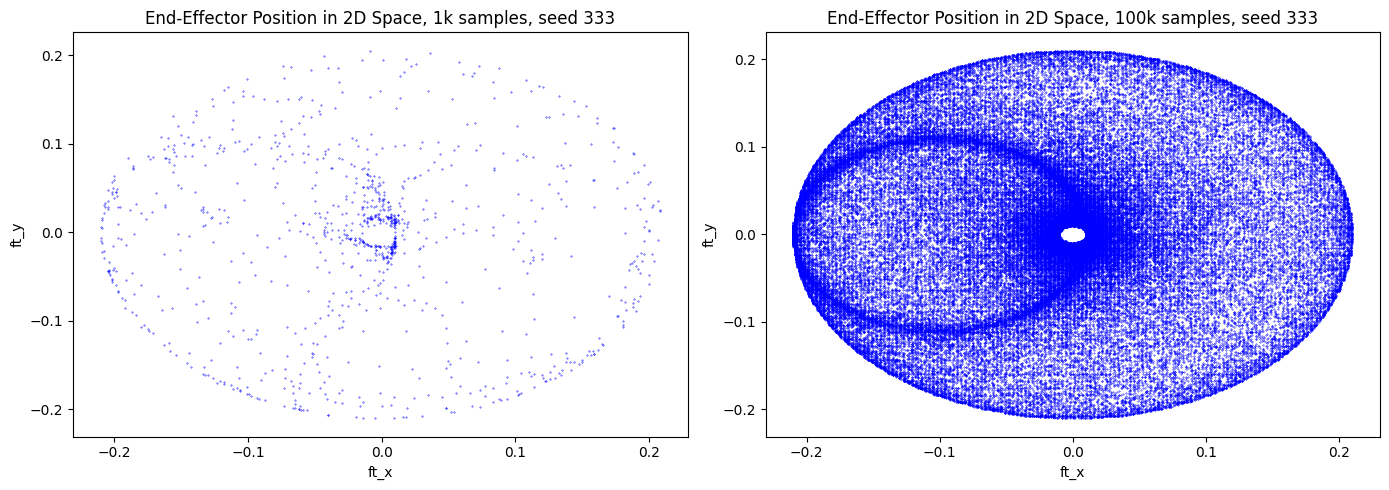

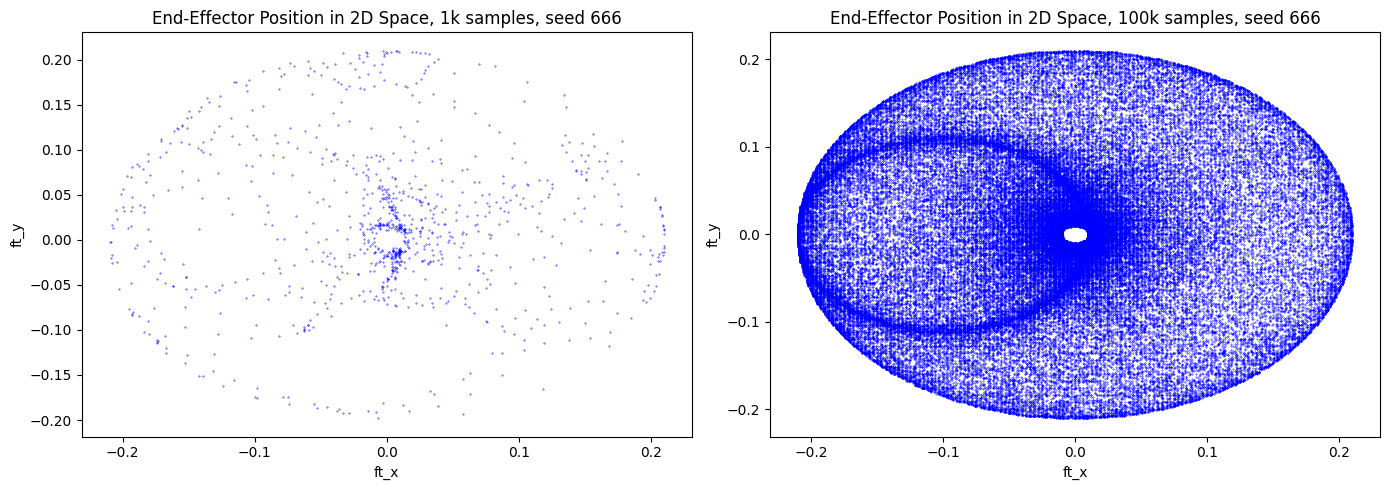

In [ ]:
def ee_pos_2d_(df1, df2, strg1, strg2, seed):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

  ax1.scatter(df1['ft_x'], df1['ft_y'], c='blue', marker='o', s=0.1)
  ax1.set_xlabel('ft_x')
  ax1.set_ylabel('ft_y')
  ax1.set_title('End-Effector Position in 2D Space, ' + strg1 + ", seed " + seed)

  ax2.scatter(df2['ft_x'], df2['ft_y'], c='blue', marker='o', s=0.1)
  ax2.set_xlabel('ft_x')
  ax2.set_ylabel('ft_y')
  ax2.set_title('End-Effector Position in 2D Space, ' + strg2 + ", seed " + seed)

  plt.tight_layout()
  plt.show()

ee_pos_2d_(df_1k_train_DA, df_train_DA, "1k samples", "100k samples", seed_train)
ee_pos_2d_(df_1k_test_DA, df_test_DA, "1k samples", "100k samples", seed_test)

##Deep Ensembles

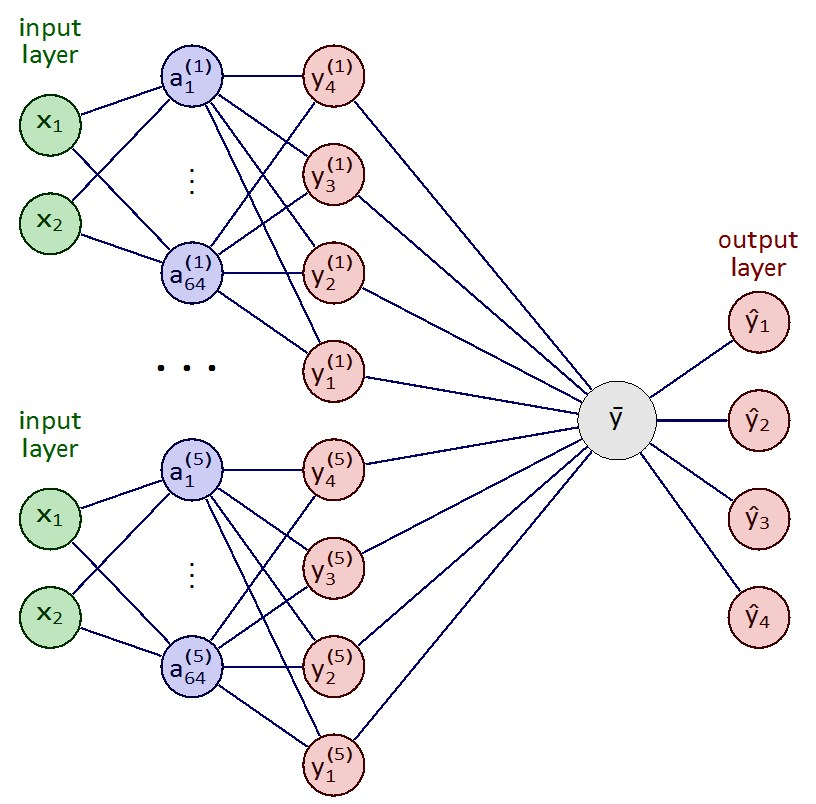

In [ ]:
def train_ensembles_w_CV(model, X_train, y_train, param_grid, seed):
  scorer = make_scorer(mean_squared_error, greater_is_better=False)
  cv = KFold(n_splits=5, shuffle=True, random_state=seed) #use a different seed for each model in the ensemble
  grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=cv, verbose=10)
  grid_result = grid.fit(X_train, y_train, verbose = 0)
  print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  return grid_result

def train_ensemble(base_model_func, X_train, y_train, param_grid, n_ensemble=5):
    ensemble = []
    for i in range(n_ensemble):
        print(f"\n\nTraining model {i+1}/{n_ensemble}...")
        model = KerasRegressor(
            model=base_model_func,
            loss='mse',
            optimizer='adam',
            metrics=['mae'],
            random_state=i #for each model ensure a different weight init
        )
        trained_model = train_ensembles_w_CV(model, X_train, y_train, param_grid, i)
        trained_model.best_estimator_.model_.save_weights(f'pesi_mod_{i}_R2_100k.weights.h5')
        ensemble.append(trained_model)
    return ensemble

def ensemble_predict(ensemble, X):
    print("Ensemble MEAN predictions")
    #ensemble is the grid results for each model, so from it pick the best_estimator
    predictions = np.array([model.best_estimator_.predict(X) for model in ensemble])
    return np.mean(predictions, axis=0)

def ensemble_weighted_predict(ensemble, X):
    #ensemble is the grid results so you can take the best score
    ensemble_scores = [model.best_score_ for model in ensemble]
    weights = 1 / np.array(ensemble_scores)  # Weights are inverse of scores
    weights = weights / np.sum(weights)  # Normalize weights to sum to 1
    print("Ensemble WEIGHTED MEAN predictions")
    print(f"Weights: {weights}")
    predictions = np.array([model.best_estimator_.predict(X) for model in ensemble])
    weighted_predictions = np.average(predictions, axis=0, weights=weights)
    return weighted_predictions

def create_shallow_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(4)
    ])
    return model

def evaluate_ensable(ensemble, X_test, y_test, weighted):
    if weighted:
        ensemble_predictions = ensemble_weighted_predict(ensemble, X_test)
    else:
        ensemble_predictions = ensemble_predict(ensemble, X_test)
    pos_error = np.mean(np.sum((ensemble_predictions[:, :2] - y_test[:, :2])**2, axis=1))
    orient_error = np.mean(np.sum((ensemble_predictions[:, 2:] - y_test[:, 2:])**2, axis=1))
    tot_error = mean_squared_error(y_test, ensemble_predictions)
    print(f"Total error: {tot_error:.6f}")
    print(f"Ensemble Position Error: {pos_error:.6f}")
    print(f"Ensemble Orientation Error: {orient_error:.6f}")
    return tot_error, pos_error, orient_error

In [ ]:
def plot_loss_curves_R2(history, model_number):
  plt.figure(figsize=(6, 3))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Loss Curves - Model {model_number}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  #set y-axis limits
  y_min = min(min(history.history['loss']), min(history.history['val_loss']))
  y_max = max(max(history.history['loss']), max(history.history['val_loss']))
  plt.ylim(y_min, y_max)
  plt.show()

def plot_loss_ensemble(ensemble, X_train, y_train, val_dim):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=val_dim, random_state=42)
    for i, model in enumerate(ensemble):
        tf.random.set_seed(42)
        #best hyperparameters
        best_lr = model.best_estimator_.get_params()['optimizer__learning_rate']
        best_batch = model.best_estimator_.get_params()['batch_size']
        best_epoch = model.best_estimator_.get_params()['epochs']

        # Recreate a new model instance (reinitialize weights)
        fresh_model = create_shallow_model()
        fresh_model.compile(loss='mse', optimizer=Adam(learning_rate=best_lr))
        history = fresh_model.fit(
            X_train_split, y_train_split,
            epochs=best_epoch,
            batch_size=best_batch,
            validation_data=(X_val, y_val),
            verbose=0
        )
        plot_loss_curves_R2(history, i + 1)

def plot_true_vs_pred_positions_R2(ensemble, y_test, weighted, strg, dim):
    if weighted:
        predictions = ensemble_weighted_predict(ensemble, X_test)
    else:
        predictions = ensemble_predict(ensemble, X_test)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    true_x = y_test[:, 0]
    true_y = y_test[:, 1]
    pred_x = predictions[:, 0]
    pred_y = predictions[:, 1]
    ax.scatter(true_x, true_y, c='blue', label='True Position', alpha=0.6, s=dim)
    ax.scatter(pred_x, pred_y, c='red', label='Predicted Position', alpha=0.6, s=dim)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    plt.title('True vs. Predicted End-Effector Position in 2D, '+ strg)
    plt.legend()
    plt.show()

Overview of the model

In [ ]:
base_model = create_shallow_model()
base_model.summary()

Model: "sequential_311"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_622 (Dense)                    │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_623 (Dense)                    │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452 (1.77 KB)

 Trainable params: 452 (1.77 KB)

 Non-trainable params: 0 (0.00 B)

###1k samples

In [ ]:
data_path_train = "/content/drive/MyDrive/Dataset_HW_ML/R2/r2_333_100k.csv"
data_path_test  = "/content/drive/MyDrive/Dataset_HW_ML/R2/r2_666_100k.csv"

dataset_dim = 1000
test_perc = 0.3
norm = False
X_train, _, X_test, y_train, _, y_test = create_dataset_R2(data_path_train, data_path_test, dataset_dim, test_perc, norm)

param_grid_R2 = {
  'epochs': [150, 300],
  'batch_size': [16, 32, 64],
  'optimizer__learning_rate' : [0.001, 0.01]
}

num_ensemble = 5
ensemble_1k = train_ensemble(create_shallow_model, X_train, y_train, param_grid_R2, n_ensemble=num_ensemble)



Training model 1/5...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START batch_size=16, epochs=150, optimizer__learning_rate=0.001..
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[CV 1/5; 1/12] END batch_size=16, epochs=150, optimizer__learning_rate=0.001;, score=-0.000 total time=  13.1s
[CV 2/5; 1/12] START batch_size=16, epochs=150, optimizer__learning_rate=0.001..
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[CV 2/5; 1/12] END batch_size=16, epochs=150, optimizer__learning_rate=0.001;, score=-0.000 total time=  11.6s
[CV 3/5; 1/12] START batch_size=16, epochs=150, optimizer__learning_rate=0.001..
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 3/5; 1/12] END batch_size=16, epochs=150, optimizer__learning_rate=0.001;, score=-0.001 total time=  11.4s
[CV 4/5; 1/12] START batch_size=16, epochs=150, optimizer__learning_rate=0.001..
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 4/5; 1/12] END batch_size=16, epochs=150, optimizer__learning_rate=0.001;, score=-0.000 total time=  19.

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[CV 2/5; 5/12] END batch_size=32, epochs=150, optimizer__learning_rate=0.001;, score=-0.001 total time=  10.4s
[CV 3/5; 5/12] START batch_size=32, epochs=150, optimizer__learning_rate=0.001..
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[CV 3/5; 5/12] END batch_size=32, epochs=150, optimizer__learning_rate=0.001;, score=-0.002 total time=   8.7s
[CV 4/5; 5/12] START batch_size=32, epochs=150, optimizer__learning_rate=0.001..
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[CV 4/5; 5/12] END batch_size=32, epochs=150, optimizer__learning_rate=0.001;, score=-0.001 total time=  10.3s
[CV 5/5; 5/12] START batch_size=32, epochs=150, optimizer__learning_rate=0.001..
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[CV 5/5; 5/12] END batch_size=32, epochs=150, optimizer__learning_rate=0.001;, score=-0.001 total time=  10.7s
[CV 1/5; 6/12] START batch_size=32, epochs=150, optimizer__learning_rate=0.01...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[CV 1/5; 6/12] END batch_size=32, epochs=1

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best: -0.000121 using {'batch_size': 16, 'epochs': 300, 'optimizer__learning_rate': 0.001}


Training model 2/5...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START batch_size=16, epochs=150, optimizer__learning_rate=0.001..
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 1/5; 1/12] END batch_size=16, epochs=150, optimizer__learning_rate=0.001;, score=-0.000 total time=  11.5s
[CV 2/5; 1/12] START batch_size=16, epochs=150, optimizer__learning_rate=0.001..
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[CV 2/5; 1/12] END batch_size=16, epochs=150, optimizer__learning_rate=0.001;, score=-0.000 total time=  12.8s
[CV 3/5; 1/12] START batch_size=16, epochs=150, optimizer__learning_rate=0.001..
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[CV 3/5; 1/12] END batch_size=16, epochs=150, optimizer__learning_rate=0.001;, score=-0.000 total time=  12.1s
[CV 4/5; 1/12] START batch_size=16, epochs=150, optimizer__learning_rate=0.001..
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
[CV 4/5; 1/12

Show the difference between weighted and mean prediction

In [ ]:
weighted_pred = True
tot_error, pos_error, orient_error = evaluate_ensable(ensemble_1k, X_test, y_test, weighted_pred)

weighted_pred = False
tot_error, pos_error, orient_error = evaluate_ensable(ensemble_1k, X_test, y_test, weighted_pred)

Ensemble WEIGHTED MEAN predictions
Weights: [0.1924771  0.20433193 0.17923989 0.20424186 0.21970922]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Total error: 0.00004
Ensemble Position Error: 0.00003
Ensemble Orientation Error: 0.00011
Ensemble MEAN predictions
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Total error: 0.00004
Ensemble Position Error: 0.00004
Ensemble Orientation Error: 0.00011


Plot the loss curves <train, val> for each models in the Deep Ensembles, using 1k samples

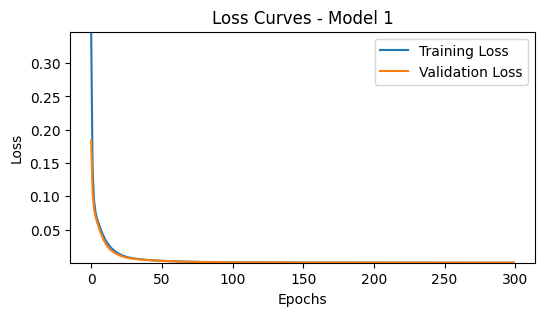

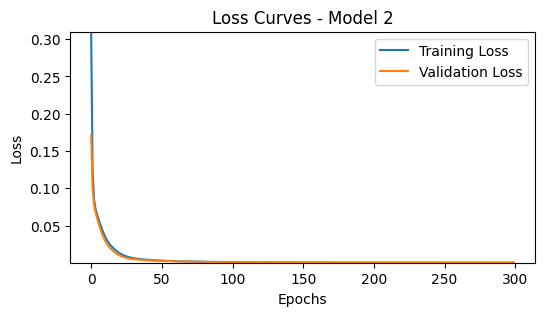

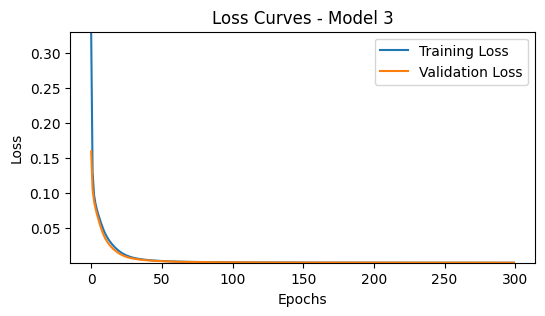

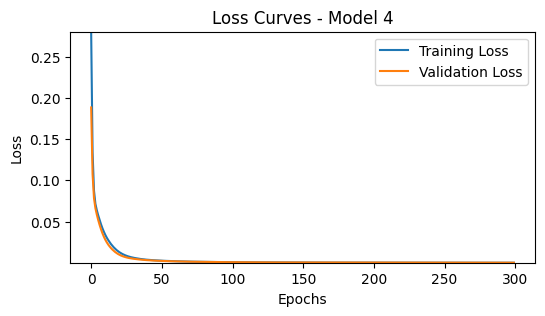

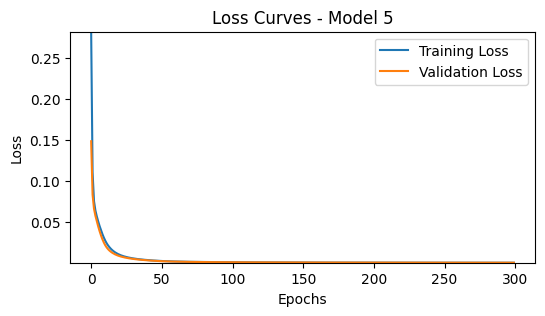

In [ ]:
val_dim = 0.2
plot_loss_ensemble(ensemble_1k, X_train, y_train, val_dim)

Ensemble WEIGHTED MEAN predictions
Weights: [0.1924771  0.20433193 0.17923989 0.20424186 0.21970922]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


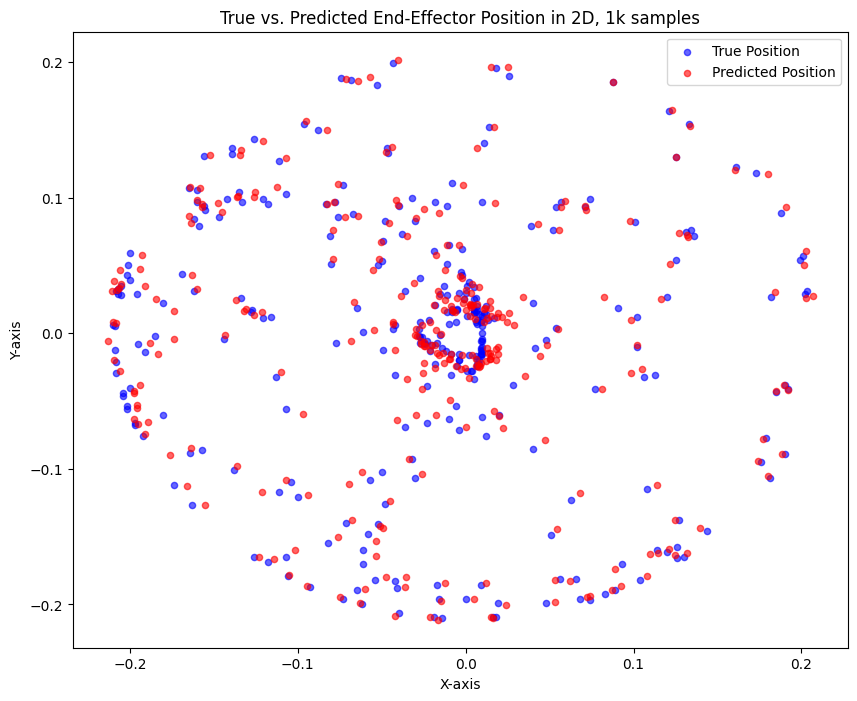

In [ ]:
weighted = True
strg = "1k samples"
plot_true_vs_pred_positions_R2(ensemble_1k, y_test, weighted, strg, 20)

###100k samples

In [ ]:
data_path_train = "/content/drive/MyDrive/Dataset_HW_ML/R2/r2_333_100k.csv"
data_path_test  = "/content/drive/MyDrive/Dataset_HW_ML/R2/r2_666_100k.csv"

dataset_dim = 100000
test_perc = 0.3
norm = False
X_train, _, X_test, y_train, _, y_test = create_dataset_R2(data_path_train, data_path_test, dataset_dim, test_perc, norm)

param_grid_R2 = {
  'epochs': [50],
  'batch_size': [16],
  'optimizer__learning_rate' : [0.001]
}

num_ensemble = 5
ensemble_100k = train_ensemble(create_shallow_model, X_train, y_train, param_grid_R2, n_ensemble=num_ensemble)



Training model 1/5...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START batch_size=16, epochs=50, optimizer__learning_rate=0.001....
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[CV 1/5; 1/1] END batch_size=16, epochs=50, optimizer__learning_rate=0.001;, score=-0.000 total time= 5.0min
[CV 2/5; 1/1] START batch_size=16, epochs=50, optimizer__learning_rate=0.001....
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[CV 2/5; 1/1] END batch_size=16, epochs=50, optimizer__learning_rate=0.001;, score=-0.000 total time= 4.4min
[CV 3/5; 1/1] START batch_size=16, epochs=50, optimizer__learning_rate=0.001....
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[CV 3/5; 1/1] END batch_size=16, epochs=50, optimizer__learning_rate=0.001;, score=-0.000 total time= 4.6min
[CV 4/5; 1/1] START batch_size=16, epochs=50, optimizer__learning_rate=0.001....
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[CV 4/5; 1/1] END batch_size=16, epochs=50, optimizer__learning_rate=0.001;, score=-0.000 total time= 

Show the difference between weighted and mean prediction

In [ ]:
weighted_pred = True
tot_error, pos_error, orient_error = evaluate_ensable(ensemble_100k, X_test, y_test, weighted_pred)

weighted_pred = False
tot_error, pos_error, orient_error = evaluate_ensable(ensemble_100k, X_test, y_test, weighted_pred)

Ensemble WEIGHTED MEAN predictions
Weights: [0.18044695 0.27841747 0.18839569 0.16543448 0.18730541]
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Total error: 0.000005
Ensemble Position Error: 0.000006
Ensemble Orientation Error: 0.000016
Ensemble MEAN predictions
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Total error: 0.000005
Ensemble Position Error: 0.000005
Ensemble Orientation Error: 0.000016


Plot the loss curves <train, val> for each models in the Deep Ensembles, using 100k samples

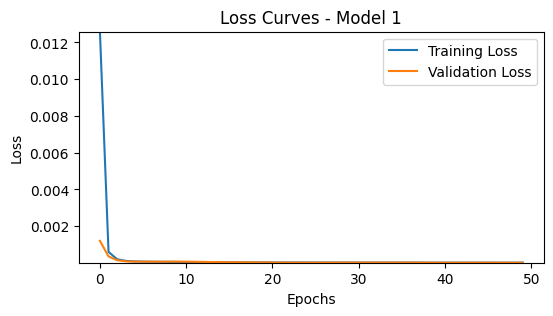

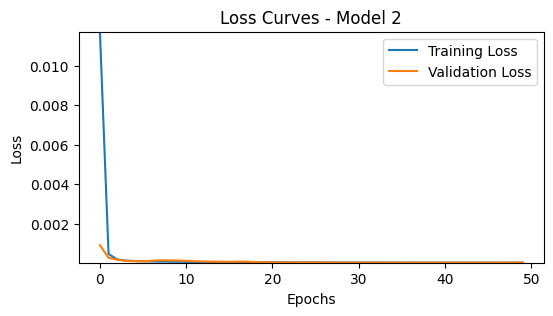

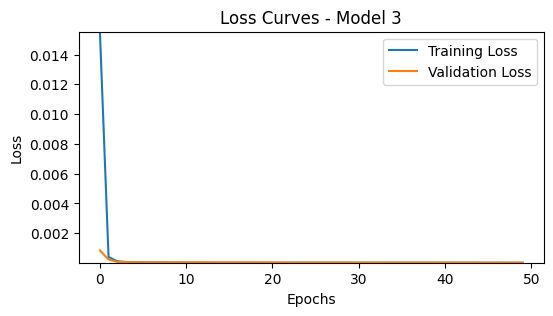

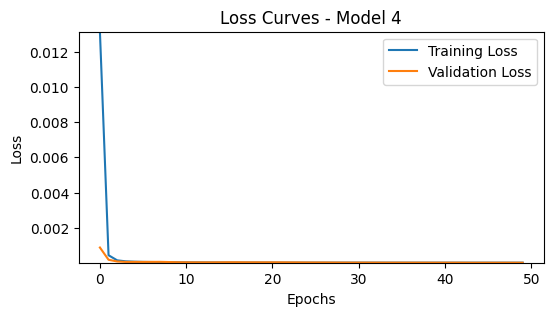

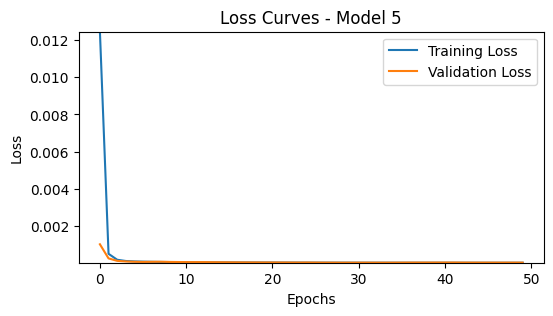

In [ ]:
val_dim = 0.2
plot_loss_ensemble(ensemble_100k, X_train, y_train, val_dim)

Ensemble WEIGHTED MEAN predictions
Weights: [0.18044695 0.27841747 0.18839569 0.16543448 0.18730541]
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


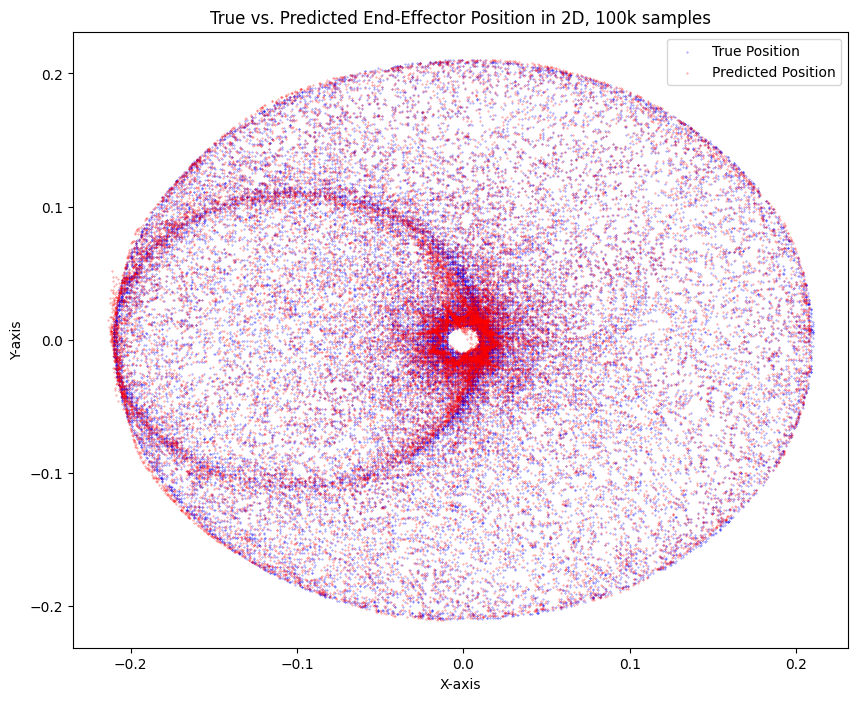

In [ ]:
weighted = True
strg = "100k samples"
plot_true_vs_pred_positions_R2(ensemble_100k, y_test, weighted, strg, 0.1)

###Jacobian computation, comparison

In [ ]:
def print_jac(jacobian, string_to_print):
  print(string_to_print)
  for row in jacobian:
    print([f'{val:.8f}' for val in row])

def FK_2in_4out(model, theta):
    t = tf.reshape(theta, shape=(1,2))
    out = model.model_(t)
    out = tf.reshape(out, shape=(4,))
    return out

def analytical_Jacobian_R2(joint_angles):
    j0, j1 = joint_angles[0], joint_angles[1]
    l1, l2 = 0.1, 0.1  #link lengths of 0.1
    J11 = -l1 * np.sin(j0) - l2 * np.sin(j0 + j1)
    J12 = -l2 * np.sin(j0 + j1)
    J21 = l1 * np.cos(j0) + l2 * np.cos(j0 + j1)
    J22 = l2 * np.cos(j0 + j1)
    J = np.array([[J11, J12],
                  [J21, J22]])
    return J

def FK_Jacobian_ensemble(models, x):
    jacobians = []
    for model in models:
        model = model.best_estimator_
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            y = FK_2in_4out(model, x)
        jacobian = tape.jacobian(y, x)
        jacobians.append(jacobian)
    return jacobians

def similarity_score(J_learned, J_analytical):
    frobenius_distance = np.linalg.norm(J_learned - J_analytical, ord='fro')
    # print(f"frobenius_distance: {frobenius_distance:.4f}")
    return frobenius_distance

def comparison_ensemble(models, X_test, comparison_num, weighted, verbose):
    """
    Compare the learned Jacobians from a deep ensemble to the analytical Jacobian.
    """
    frobenius_distances = []
    random.seed(42)
    random_indices = random.sample(range(len(X_test)), comparison_num)
    for index in random_indices:
      x = X_test[index]
      t = tf.constant(x, dtype=tf.float32)

      # Compute Jacobians for the ensemble
      jacobians_ensemble = FK_Jacobian_ensemble(models, t)
      if weighted:
          ensemble_scores = [model.best_score_ for model in models]
          weights = 1 / np.array(ensemble_scores)
          weights = weights / np.sum(weights)
          learned_j = np.average(jacobians_ensemble, axis=0, weights=weights)[:2, :]
      else:
          learned_j = np.mean(jacobians_ensemble, axis=0)[:2, :] #first 2 rows, because interested in position

      # Compute analytical Jacobian for the same input
      joint_angles = x[:2]  # Only the first two values (angles)
      J_analytical = analytical_Jacobian_R2(joint_angles)

      frb_dist = similarity_score(learned_j, J_analytical)
      frobenius_distances.append(frb_dist)
      if verbose:
        print("Learned Jacobian positions for each model belonging to Deep Ensemble:")
        for i, J_learned in enumerate(jacobians_ensemble):
            J_learned_position = J_learned.numpy()[:2, :]
            to_print = "Model: "+str(i+1)
            print_jac(J_learned_position, to_print)
            print()
        print_jac(learned_j, "Mean Jacobian:")
        print_jac(J_analytical, "\nAnalytical Jacobian position:")
        print("\n\n")

    print(f"Mean Frobenius Distance: {np.mean(frobenius_distances):.4f}")
    print(f"Frobenius Distance StdDev: {np.std(frobenius_distances):.4f}")

####Model trained on 1k

In [ ]:
verbose_comp = False
weighted = True
num_of_comparison = 50
print("Results with weighted prediction")
comparison_ensemble(ensemble_1k, X_test, num_of_comparison, weighted, verbose_comp)

print("\nResults with mean prediction")
weighted = False
comparison_ensemble(ensemble_1k, X_test, num_of_comparison, weighted, verbose_comp)

Results with weighted prediction
Mean Frobenius Distance: 0.0356
Frobenius Distance StdDev: 0.0140


Results with mean prediction
Mean Frobenius Distance: 0.0357
Frobenius Distance StdDev: 0.0142


####Model trained on 100k

In [ ]:
verbose_comp = False
weighted = True
num_of_comparison = 50
print("Results with weighted prediction")
comparison_ensemble(ensemble_100k, X_test, num_of_comparison, weighted, verbose_comp)

print("\nResults with mean prediction")
weighted = False
comparison_ensemble(ensemble_100k, X_test, num_of_comparison, weighted, verbose_comp)

Results with weighted prediction
Mean Frobenius Distance: 0.0234
Frobenius Distance StdDev: 0.0080


Results with mean prediction
Mean Frobenius Distance: 0.0229
Frobenius Distance StdDev: 0.0077


#R3

##Dataset exploration

In [ ]:
current_dir = "/content/drive/MyDrive/Dataset_HW_ML/R3"
for file in os.listdir(current_dir):
      file_path = os.path.join(current_dir, file)
      df = pd.read_csv(file_path)

data_path_train = "/content/drive/MyDrive/Dataset_HW_ML/R3/r3_333_100k.csv"
data_path_test  = "/content/drive/MyDrive/Dataset_HW_ML/R3/r3_666_100k.csv"

df_train_DA = pd.read_csv(data_path_train, sep=';')
df_train_DA.columns = ['j0', 'j1', 'j2', 'cos(j0)', 'cos(j1)',	'cos(j2)', 'sin(j0)', 'sin(j1)', 'sin(j2)',	'ft_x',	'ft_y',	'ft_qw', 'ft_qz']

df_test_DA = pd.read_csv(data_path_test, sep=';')
df_test_DA.columns = ['j0', 'j1', 'j2', 'cos(j0)', 'cos(j1)',	'cos(j2)', 'sin(j0)', 'sin(j1)', 'sin(j2)',	'ft_x',	'ft_y',	'ft_qw', 'ft_qz']

df_1k_train_DA = df_train_DA.copy().iloc[:1000]
df_1k_test_DA = df_test_DA.copy().iloc[:1000]

seed_train = "333"
seed_test = "666"

df_train_DA.head()

j0     j1     j2  cos(j0)  cos(j1)  cos(j2)  sin(j0)  sin(j1)  sin(j2)  \
0  0.084  0.066  0.011    0.996    0.998    1.000    0.084    0.066    0.011   
1  0.117  0.093  0.015    0.993    0.996    1.000    0.117    0.092    0.015   
2  0.207  0.182  0.033    0.979    0.984    0.999    0.205    0.181    0.033   
3  0.341  0.313  0.085    0.942    0.951    0.996    0.334    0.308    0.085   
4  0.461  0.434  0.190    0.895    0.907    0.982    0.445    0.421    0.189   

    ft_x   ft_y  ft_qw  ft_qz  
0  0.307  0.041  0.997  0.080  
1  0.304  0.057  0.994  0.112  
2  0.291  0.103  0.978  0.209  
3  0.255  0.168  0.932  0.361  
4  0.203  0.220  0.856  0.517

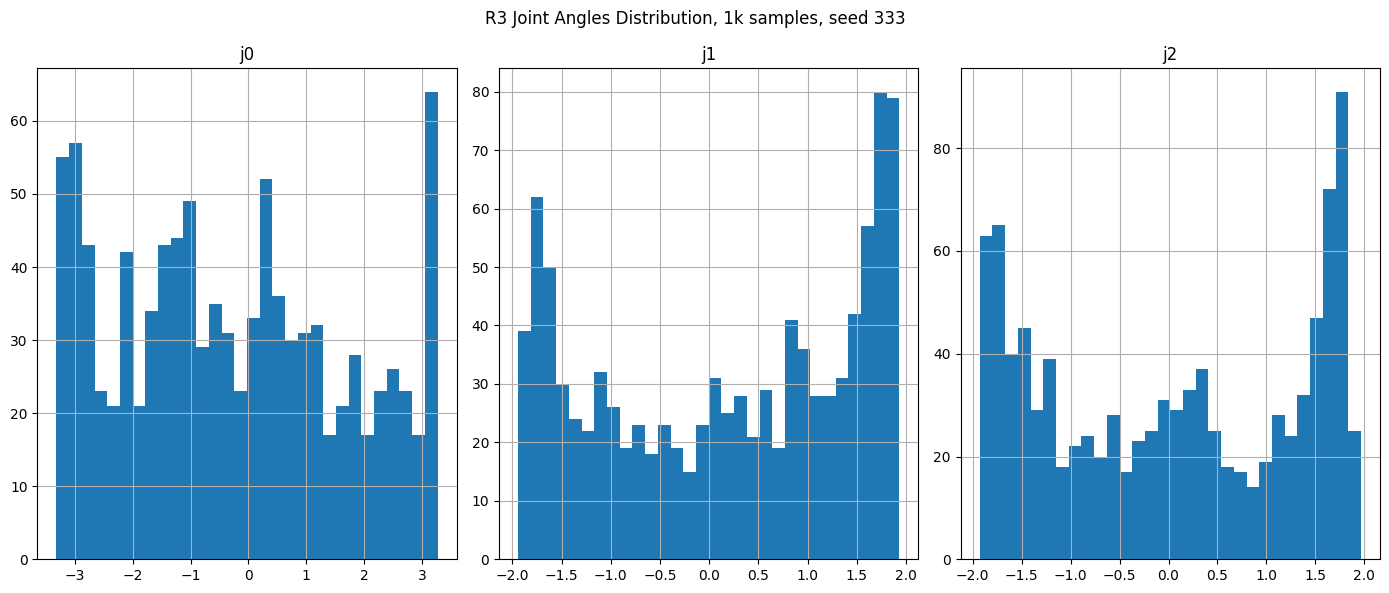

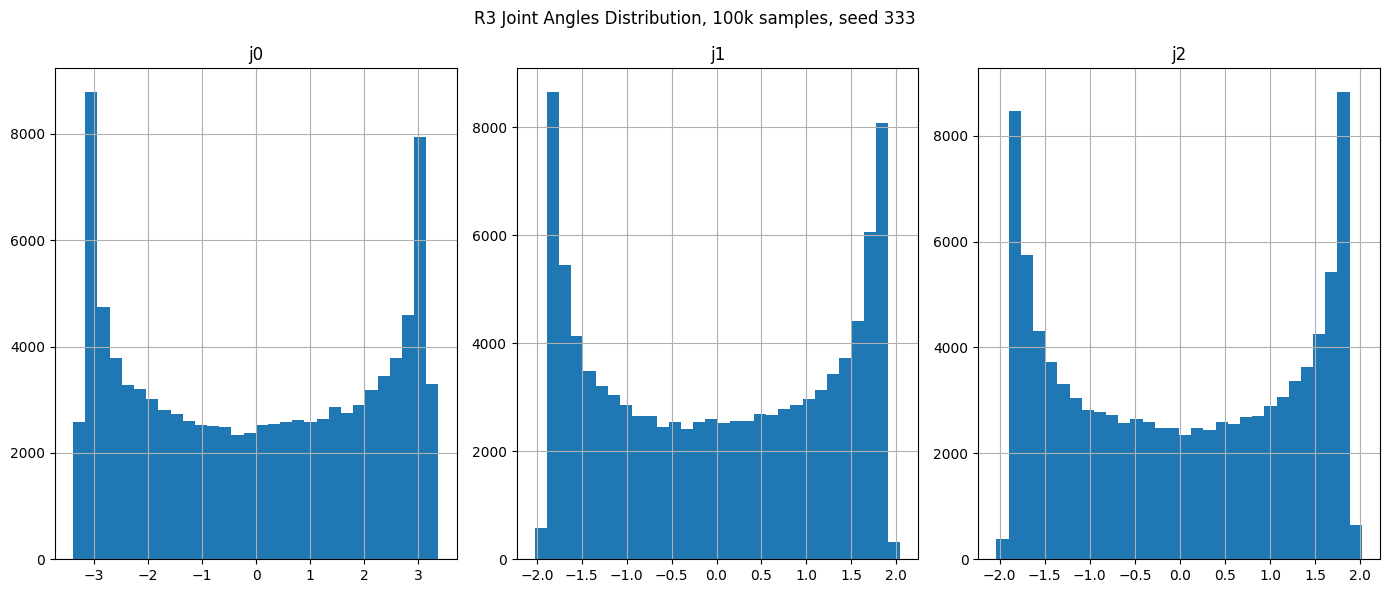

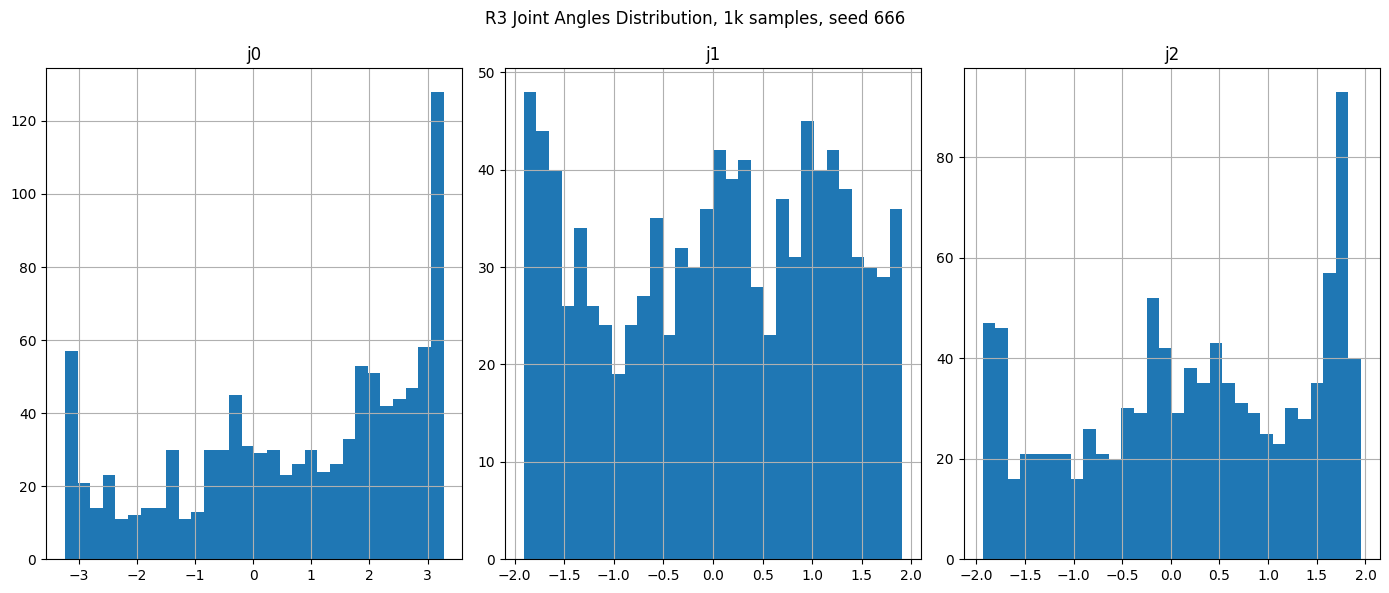

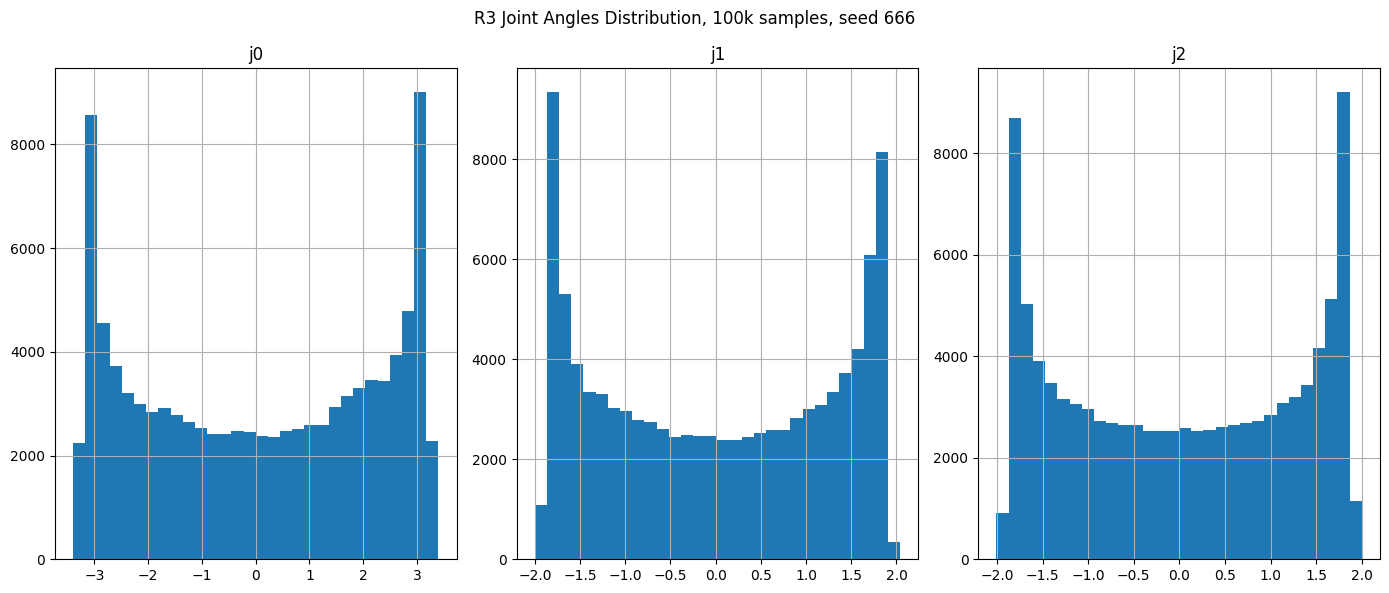

In [ ]:
def hist_plot_R3(df,strg, seed):
  fig, axes = plt.subplots(1, 3, figsize=(14, 6))
  df[['j0', 'j1', 'j2']].hist(ax=axes, bins=30)
  plt.suptitle('R3 Joint Angles Distribution, '+strg+", seed "+seed)
  plt.tight_layout()
  plt.show()

hist_plot_R3(df_1k_train_DA,"1k samples",seed_train)
hist_plot_R3(df_train_DA,"100k samples",seed_train)
print("\n")
hist_plot_R3(df_1k_test_DA,"1k samples",seed_test)
hist_plot_R3(df_test_DA,"100k samples",seed_test)

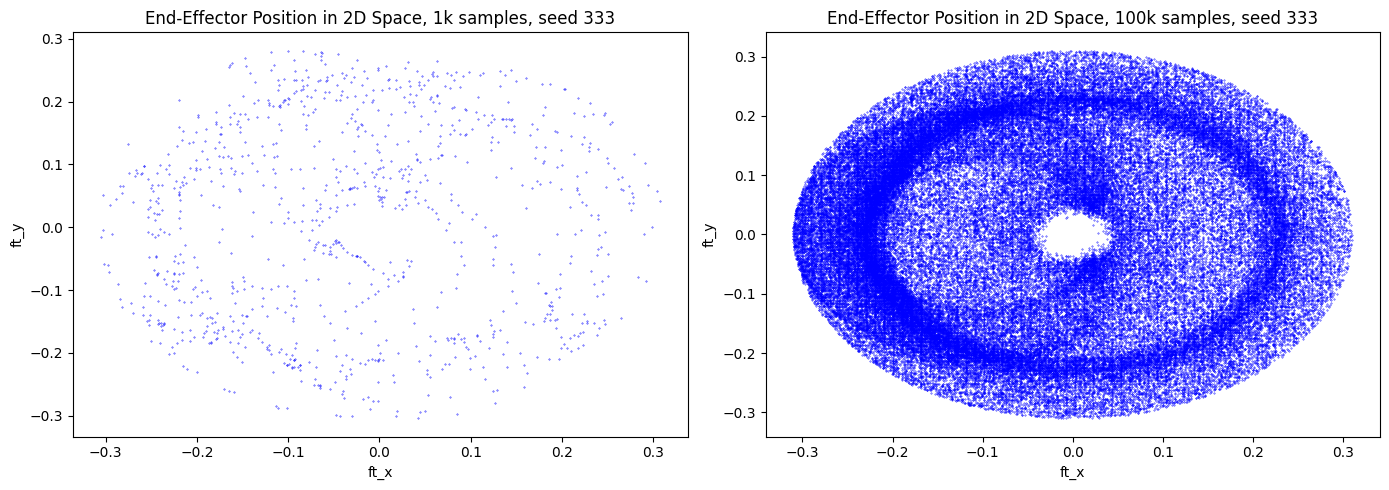

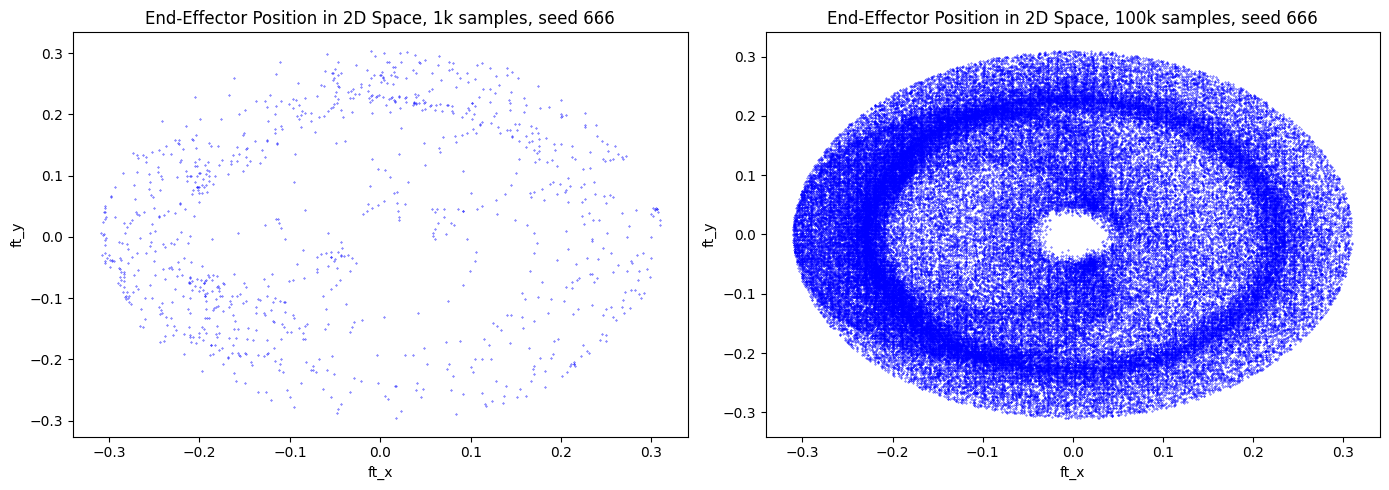

In [ ]:
ee_pos_2d_(df_1k_train_DA, df_train_DA, "1k samples", "100k samples", seed_train)
ee_pos_2d_(df_1k_test_DA, df_test_DA, "1k samples", "100k samples", seed_test)

## Adaboost-DecisionTreeRegressor

In [ ]:
def create_model_R3():
    ada_regressor = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(),
        random_state=42
    )
    model = MultiOutputRegressor(ada_regressor)
    return model

def train_model_R3(model, X_train, y_train, param_grid, num_folds):
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scorer,
        cv=num_folds,
        verbose=10
    )
    grid_res = grid_search.fit(X_train, y_train)
    print("\nBest Parameters:", grid_res.best_params_)
    print("Best Score (Negative MSE):", grid_res.best_score_)
    return grid_res.best_estimator_

def evaluate_model_R3(model, X_test, y_test):
    predictions = model.predict(X_test)
    #MSE
    pos_error = np.mean(np.sum((predictions[:, :2] - y_test[:, :2])**2, axis=1))
    orient_error = np.mean(np.sum((predictions[:, 2:] - y_test[:, 2:])**2, axis=1))
    tot_error = mean_squared_error(y_test, predictions)
    print(f"Total Error: {tot_error:.6f}")
    print(f"Position Error (meters): {pos_error:.6f}")
    print(f"Orientation Error (quaternion): {orient_error:.6f}")
    return pos_error, orient_error

In [ ]:
def plot_true_vs_pred_positions_R3(model, y_test, strg, dim):
    predictions = model.predict(X_test)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    true_x = y_test[:, 0]
    true_y = y_test[:, 1]
    pred_x = predictions[:, 0]
    pred_y = predictions[:, 1]
    ax.scatter(true_x, true_y, c='blue', label='True Position', alpha=0.6, s=dim)
    ax.scatter(pred_x, pred_y, c='red', label='Predicted Position', alpha=0.6, s=dim)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    plt.title('True vs. Predicted End-Effector Position in 2D, '+strg)
    plt.legend()
    plt.show()

###1k samples

In [ ]:
data_path_train = "/content/drive/MyDrive/Dataset_HW_ML/R3/r3_333_100k.csv"
data_path_test  = "/content/drive/MyDrive/Dataset_HW_ML/R3/r3_666_100k.csv"

dataset_dim = 1000
test_dim = 0.3
norm = False
X_train, _, X_test, y_train, _, y_test = create_dataset_R3(data_path_train, data_path_test, dataset_dim, test_dim, norm)

model = create_model_R3()

param_grid_R3 = {
    'estimator__estimator__max_depth': [8, 10, 12, 14],
    'estimator__n_estimators': [250, 500],
    'estimator__learning_rate': [0.09, 0.3, 0.9]
}

num_folds = 5
best_model_R3_1k = train_model_R3(model, X_train, y_train, param_grid_R3, num_folds)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START estimator__estimator__max_depth=8, estimator__learning_rate=0.09, estimator__n_estimators=250
[CV 1/5; 1/24] END estimator__estimator__max_depth=8, estimator__learning_rate=0.09, estimator__n_estimators=250;, score=-0.009 total time=   3.2s
[CV 2/5; 1/24] START estimator__estimator__max_depth=8, estimator__learning_rate=0.09, estimator__n_estimators=250
[CV 2/5; 1/24] END estimator__estimator__max_depth=8, estimator__learning_rate=0.09, estimator__n_estimators=250;, score=-0.007 total time=   3.4s
[CV 3/5; 1/24] START estimator__estimator__max_depth=8, estimator__learning_rate=0.09, estimator__n_estimators=250
[CV 3/5; 1/24] END estimator__estimator__max_depth=8, estimator__learning_rate=0.09, estimator__n_estimators=250;, score=-0.007 total time=   2.6s
[CV 4/5; 1/24] START estimator__estimator__max_depth=8, estimator__learning_rate=0.09, estimator__n_estimators=250
[CV 4/5; 1/24] END estimator__estimat

Evaluation results

In [ ]:
pos_error, orient_error = evaluate_model_R3(best_model_R3_1k, X_test, y_test)

Means Squared Error: 0.004041
Position Error (meters): 0.001683
Orientation Error (quaternion): 0.014479


Comparsion between the predicted positions and the true positions

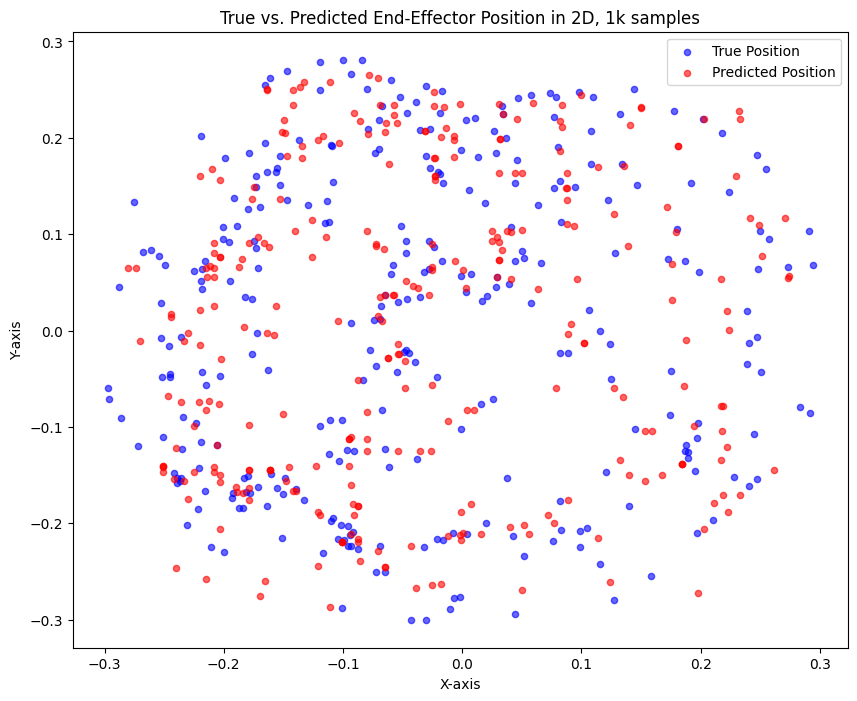

In [ ]:
strg = "1k samples"
plot_true_vs_pred_positions_R3(best_model_R3_1k, y_test, strg, 20)

###100k samples

In [ ]:
data_path_train = "/content/drive/MyDrive/Dataset_HW_ML/R3/r3_333_100k.csv"
data_path_test  = "/content/drive/MyDrive/Dataset_HW_ML/R3/r3_666_100k.csv"

dataset_dim = 100000
test_dim = 0.3
norm = False
X_train, _, X_test, y_train, _, y_test = create_dataset_R3(data_path_train, data_path_test, dataset_dim, test_dim, norm)

model = create_model_R3()

param_grid_R3 = {
    'estimator__estimator__max_depth': [12, 14],
    'estimator__n_estimators': [500],
    'estimator__learning_rate': [0.3, 0.9]
}

num_folds = 5
best_model_R3_100k = train_model_R3(model, X_train, y_train, param_grid_R3, num_folds)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START estimator__estimator__max_depth=12, estimator__learning_rate=0.3, estimator__n_estimators=500
[CV 1/5; 1/4] END estimator__estimator__max_depth=12, estimator__learning_rate=0.3, estimator__n_estimators=500;, score=-0.000 total time= 7.0min
[CV 2/5; 1/4] START estimator__estimator__max_depth=12, estimator__learning_rate=0.3, estimator__n_estimators=500
[CV 2/5; 1/4] END estimator__estimator__max_depth=12, estimator__learning_rate=0.3, estimator__n_estimators=500;, score=-0.000 total time= 6.9min
[CV 3/5; 1/4] START estimator__estimator__max_depth=12, estimator__learning_rate=0.3, estimator__n_estimators=500
[CV 3/5; 1/4] END estimator__estimator__max_depth=12, estimator__learning_rate=0.3, estimator__n_estimators=500;, score=-0.000 total time= 6.9min
[CV 4/5; 1/4] START estimator__estimator__max_depth=12, estimator__learning_rate=0.3, estimator__n_estimators=500
[CV 4/5; 1/4] END estimator__estimator__max_de

Evaluation Results

In [ ]:
pos_error, orient_error = evaluate_model_R3(best_model_R3_100k, X_test, y_test)

Means Squared Error: 0.000225
Position Error (meters): 0.000089
Orientation Error (quaternion): 0.000809


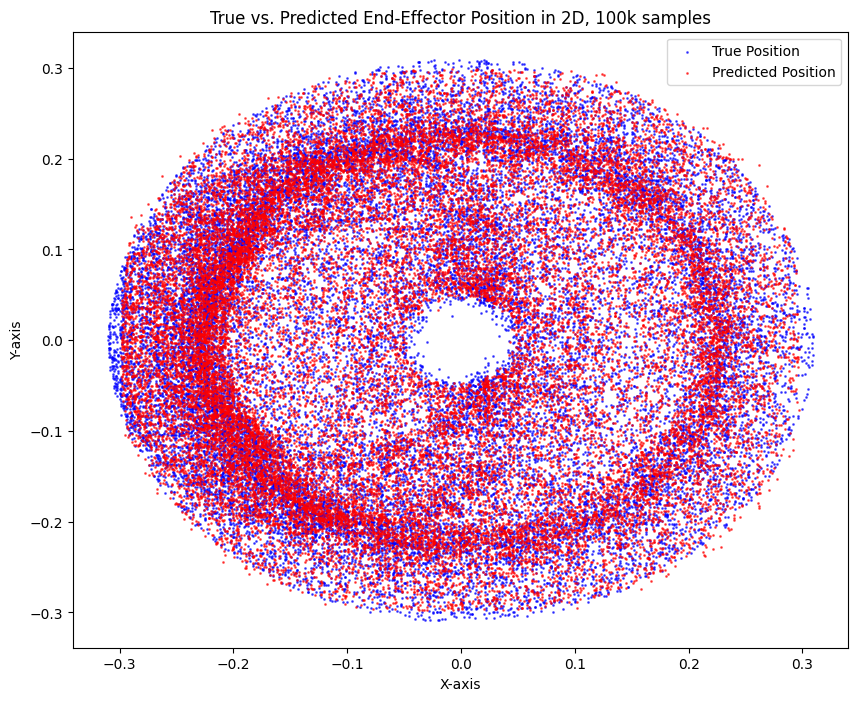

In [ ]:
strg = "100k samples"
plot_true_vs_pred_positions_R3(best_model_R3_100k, y_test, strg, 1)

###Jacobian computation, comparison

The central difference formula uses two evaluations of the function to approximate the derivative

$f'(x) \approx \frac{f(x + \epsilon) - f(x - \epsilon)}{2\epsilon}$



In [ ]:
def FK_3in_4out_adaboost(model, theta):
    out = model.predict([theta])
    out = out.reshape(4)
    return out[:2] #only position pred

def FK_Jacobian_adaboost(model, x, eps):
    J = np.zeros((2, 3))
    # Numerical differentiation for each input
    for i in range(3):  # Loop over 3 inputs
        x_plus_eps = x.copy()
        x_plus_eps[i] += eps
        y_plus_eps = FK_3in_4out_adaboost(model, x_plus_eps)
        x_minus_eps = x.copy()
        x_minus_eps[i] -= eps
        y_minus_eps = FK_3in_4out_adaboost(model, x_minus_eps)

        # Central difference approximation
        pos = (y_plus_eps - y_minus_eps) / (2 * eps)
        J[:, i] = pos
    return J

def analytical_Jacobian_3joints(joint_angles):
    j0, j1, j2 = joint_angles[0], joint_angles[1], joint_angles[2]
    l1, l2, l3 = 0.1, 0.1, 0.1

    J11 = -l1 * np.sin(j0) - l2 * np.sin(j0 + j1) - l3 * np.sin(j0 + j1 + j2)
    J12 = -l2 * np.sin(j0 + j1) - l3 * np.sin(j0 + j1 + j2)
    J13 = -l3 * np.sin(j0 + j1 + j2)
    J21 = l1 * np.cos(j0) + l2 * np.cos(j0 + j1) + l3 * np.cos(j0 + j1 + j2)
    J22 = l2 * np.cos(j0 + j1) + l3 * np.cos(j0 + j1 + j2)
    J23 = l3 * np.cos(j0 + j1 + j2)
    J = np.array([[J11, J12, J13],
                  [J21, J22, J23]])
    return J

def comparison_R3(model, X_test, comparison_num, verbose):
    frobenius_distances = []

    random_indices = random.sample(range(len(X_test)), comparison_num)
    for index in random_indices:
        x = X_test[index]
        eps = 0.1
        J_learned_position = FK_Jacobian_adaboost(model, x, eps)
        if verbose:
            print("Learned Jacobian position:")
            for row in J_learned_position:
                print([f'{val:.12f}' for val in row])

        joint_angles = x[:3]
        J_analytical = analytical_Jacobian_3joints(joint_angles)
        if verbose:
            print("\nAnalytical Jacobian position:")
            print(J_analytical)
            print("\n")

        frb_dist = similarity_score(J_learned_position, J_analytical)
        frobenius_distances.append(frb_dist)
    print(f"Mean Frobenius Distance: {np.mean(frobenius_distances):.6f}")
    print(f"Frobenius Distance StdDev: {np.std(frobenius_distances):.6f}")

####Model trained on 1k

In [ ]:
num_comp = 50
verbose = False
comparison_R3(best_model_R3_1k, X_test, num_comp, verbose)

Mean Frobenius Distance: 0.338116
Frobenius Distance StdDev: 0.220258


####Model trained on 100k

In [ ]:
num_comp = 50
verbose = False
comparison_R3(best_model_R3_100k, X_test, num_comp, verbose)

Mean Frobenius Distance: 0.077963
Frobenius Distance StdDev: 0.032074


#R5

##Dataset exploration

In [ ]:
current_dir = "/content/drive/MyDrive/Dataset_HW_ML/R5"
for file in os.listdir(current_dir):
      file_path = os.path.join(current_dir, file)
      df = pd.read_csv(file_path)

data_path_train = "/content/drive/MyDrive/Dataset_HW_ML/R5/r5_333_100k.csv"
data_path_test  = "/content/drive/MyDrive/Dataset_HW_ML/R5/r5_666_100k.csv"

df_train_DA = pd.read_csv(data_path_train, sep=';')
df_train_DA.columns = ['j0', 'j1', 'j2', 'j3', 'j4', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'cos(j3)', 'cos(j4)', 'sin(j0)', 'sin(j1)', 'sin(j2)', 'sin(j3)', 'sin(j4)', 'ft_x', 'ft_y', 'ft_z', 'ft_qw', 'ft_qx', 'ft_qy', 'ft_qz']

df_test_DA = pd.read_csv(data_path_test, sep=';')
df_test_DA.columns = ['j0', 'j1', 'j2', 'j3', 'j4', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'cos(j3)', 'cos(j4)', 'sin(j0)', 'sin(j1)', 'sin(j2)', 'sin(j3)', 'sin(j4)', 'ft_x', 'ft_y', 'ft_z', 'ft_qw', 'ft_qx', 'ft_qy', 'ft_qz']

df_1k_train_DA = df_train_DA.copy().iloc[:1000]
df_1k_test_DA = df_test_DA.copy().iloc[:1000]

seed_train = "333"
seed_test = "666"

df_train_DA.head()

j0     j1     j2     j3     j4  cos(j0)  cos(j1)  cos(j2)  cos(j3)  \
0  0.000  0.000  0.000  0.000  0.000    1.000    1.000    1.000    1.000   
1  0.033  0.026  0.004  0.024  0.037    0.999    1.000    1.000    1.000   
2  0.108  0.098  0.018  0.097  0.077    0.994    0.995    1.000    0.995   
3  0.178  0.219  0.043  0.211  0.085    0.984    0.976    0.999    0.978   
4  0.250  0.398  0.090  0.318  0.077    0.969    0.922    0.996    0.950   

   cos(j4)  ...  sin(j2)  sin(j3)  sin(j4)   ft_x   ft_y   ft_z  ft_qw  ft_qx  \
0    1.000  ...    0.000    0.000    0.000  0.000  0.000  0.590  1.000  0.000   
1    0.999  ...    0.004    0.024    0.037  0.019 -0.004  0.589  0.999  0.018   
2    0.997  ...    0.018    0.096    0.077  0.073 -0.001  0.583  0.992  0.033   
3    0.996  ...    0.043    0.209    0.085  0.159  0.018  0.557  0.968  0.021   
4    0.997  ...    0.090    0.313    0.076  0.258  0.056  0.496  0.914 -0.014   

   ft_qy  ft_qz  
0  0.000  0.000  
1  0.027  0.016  
2  0.108  0.050  
3  0.237  0.076  
4  0.393  0.100  

[5 rows x 22 columns]

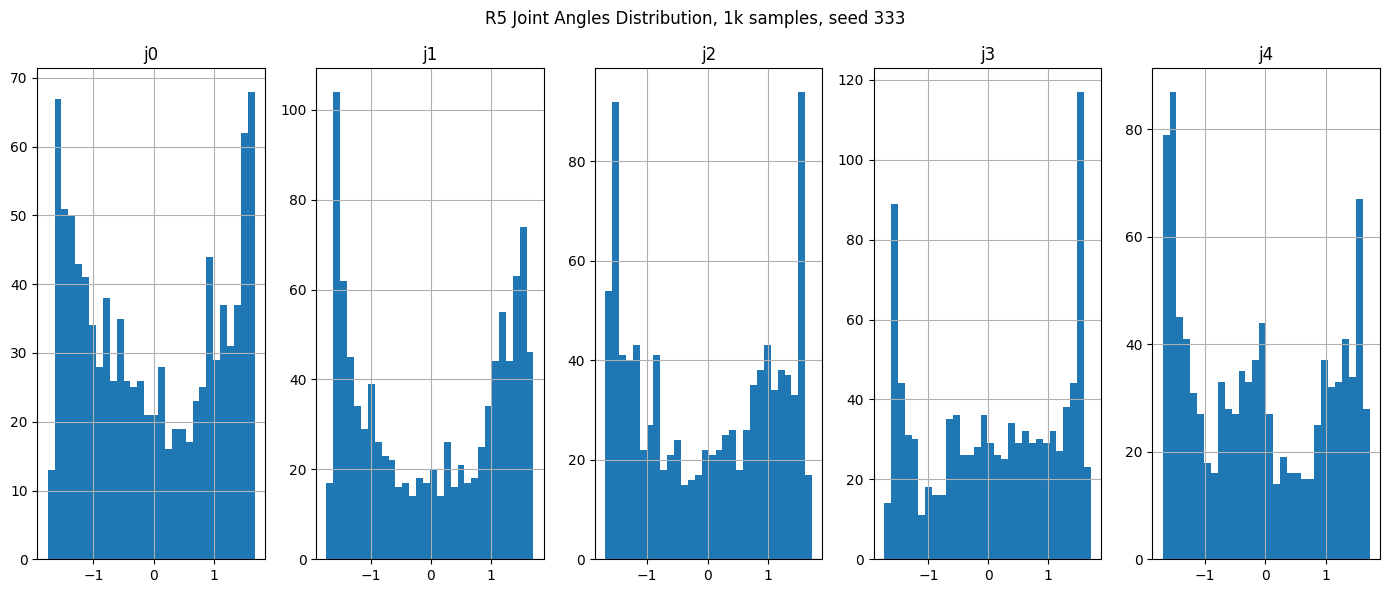

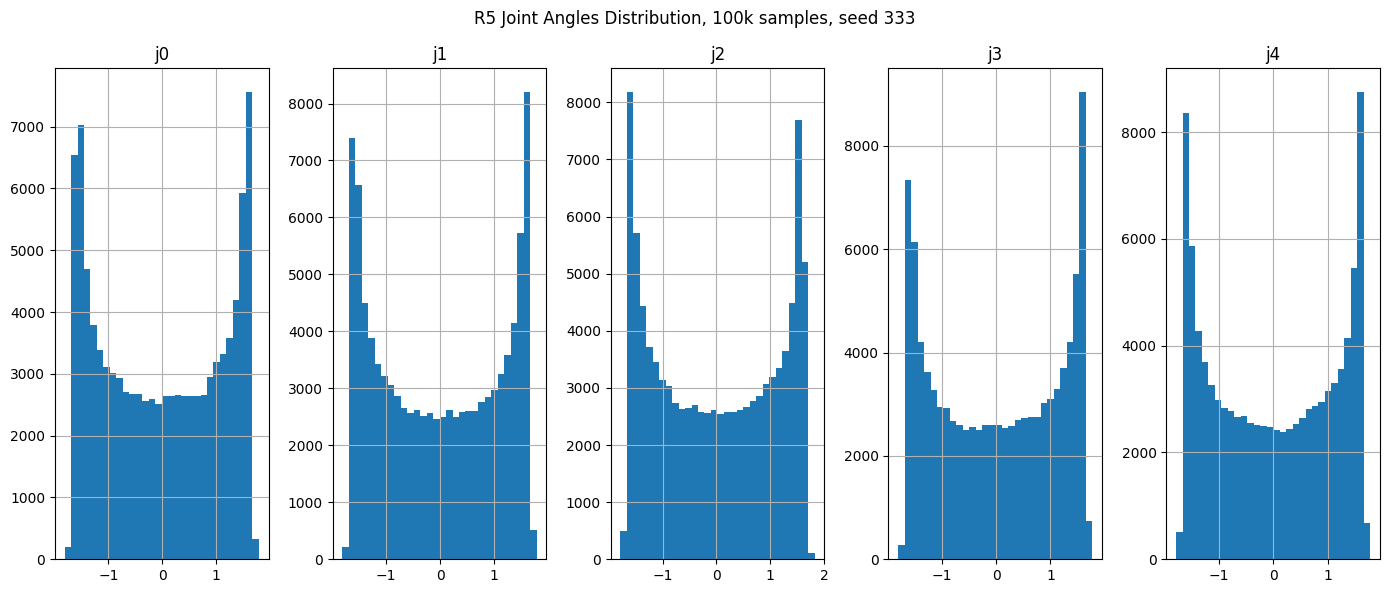

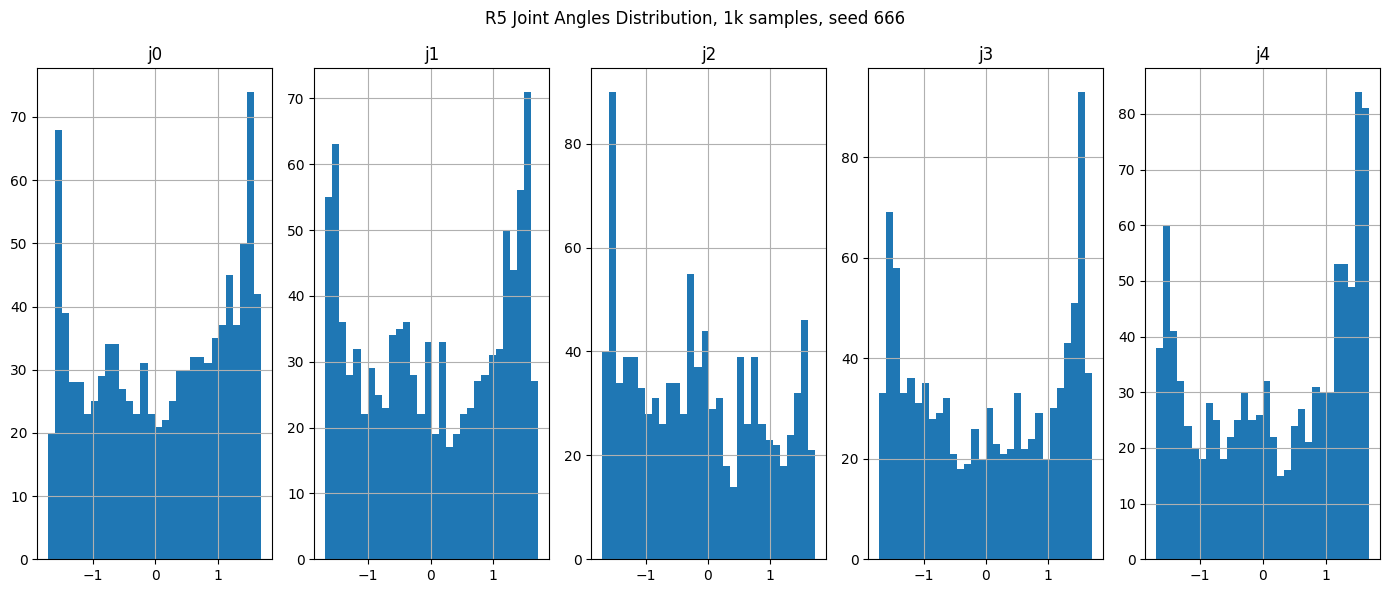

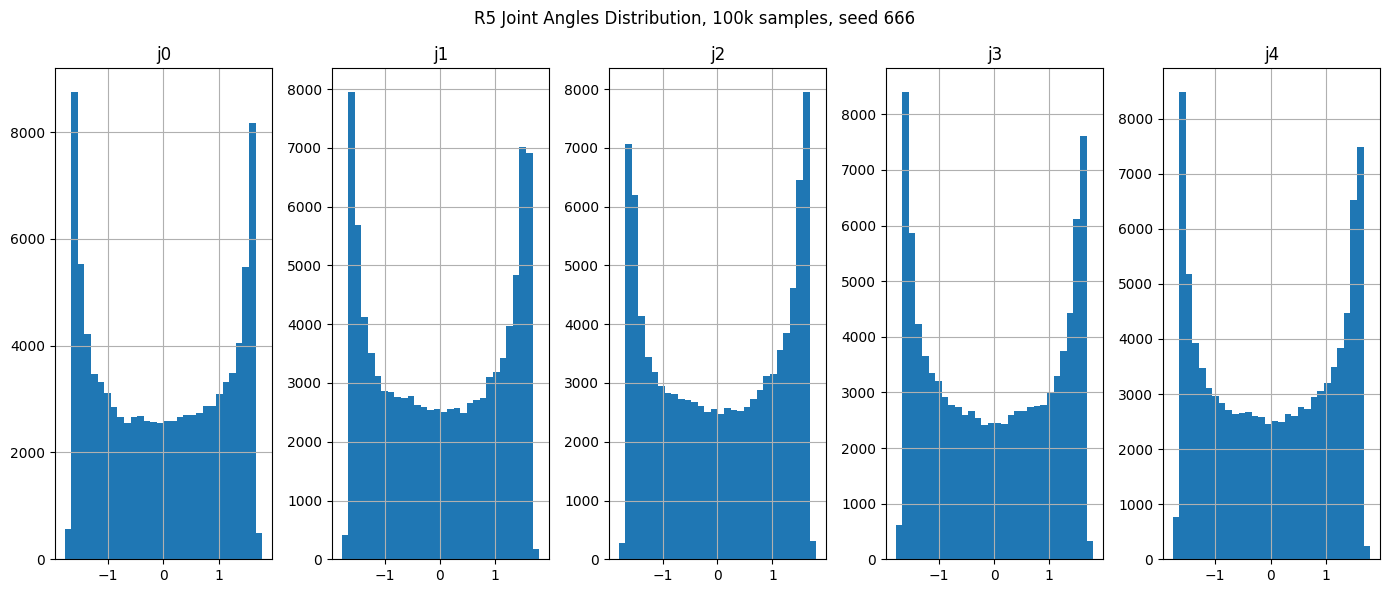

In [ ]:
def hist_plot_R5(df, strg, seed):
  fig, axes = plt.subplots(1, 5, figsize=(14, 6))
  df[['j0', 'j1', 'j2', 'j3', 'j4']].hist(ax=axes, bins=30)
  plt.suptitle('R5 Joint Angles Distribution, '+strg+", seed "+seed)
  plt.tight_layout()
  plt.show()

hist_plot_R5(df_1k_train_DA,"1k samples",seed_train)
hist_plot_R5(df_train_DA,"100k samples",seed_train)
print("\n")
hist_plot_R5(df_1k_test_DA,"1k samples",seed_test)
hist_plot_R5(df_test_DA,"100k samples",seed_test)

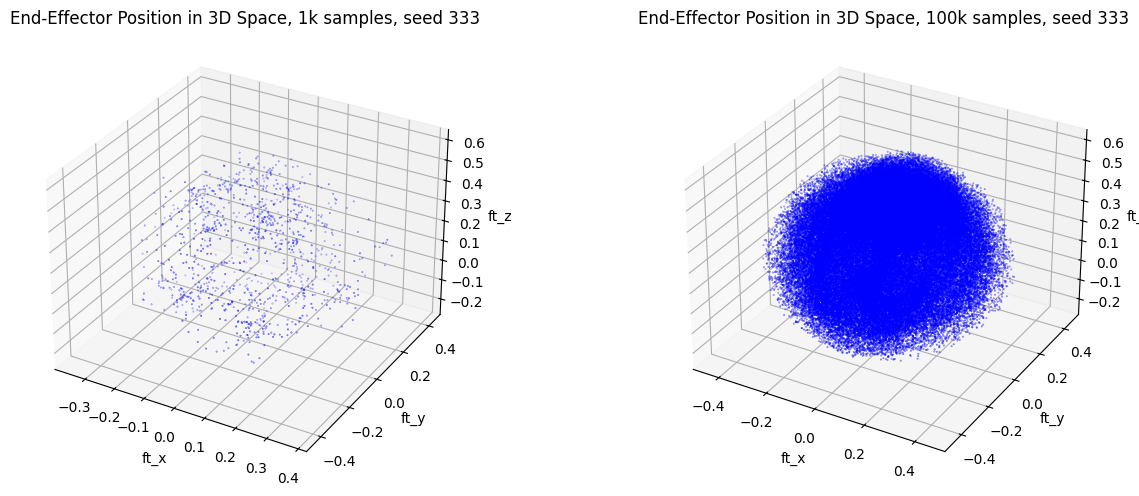

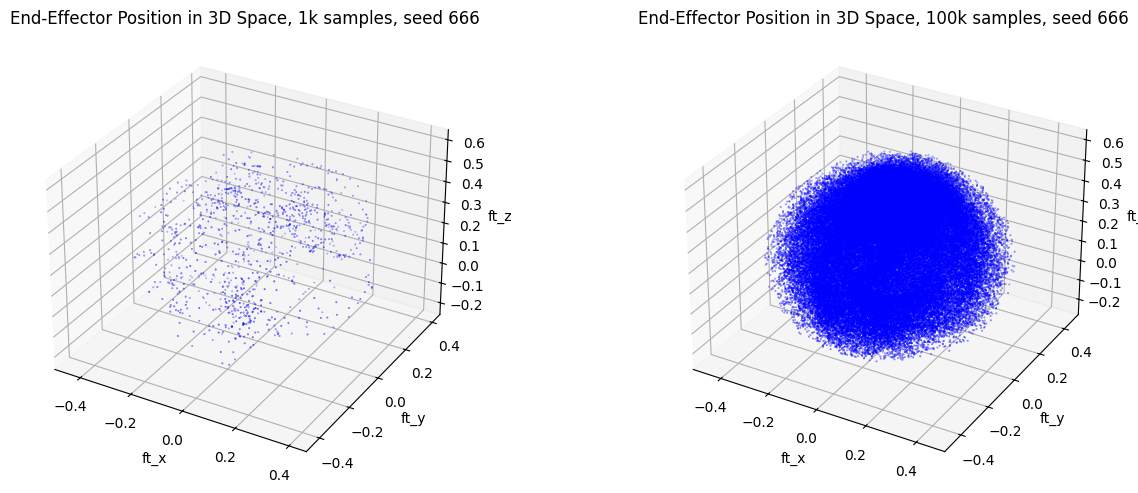

In [ ]:
def ee_pos_3d_R5_(df1, df2, strg1, strg2, seed):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), subplot_kw={'projection': '3d'})
  ax1.scatter(df1['ft_x'], df1['ft_y'], df1['ft_z'], c='blue', marker='o', s=00.1)
  ax1.set_xlabel('ft_x')
  ax1.set_ylabel('ft_y')
  ax1.set_zlabel('ft_z')
  ax1.set_title('End-Effector Position in 3D Space, ' + strg1 + ", seed " + seed)

  ax2.scatter(df2['ft_x'], df2['ft_y'], df2['ft_z'], c='blue', marker='o', s=00.1)
  ax2.set_xlabel('ft_x')
  ax2.set_ylabel('ft_y')
  ax2.set_zlabel('ft_z')
  ax2.set_title('End-Effector Position in 3D Space, ' + strg2 + ", seed " + seed)
  plt.tight_layout()
  plt.show()

ee_pos_3d_R5_(df_1k_train_DA, df_train_DA, "1k samples", "100k samples", seed_train)
ee_pos_3d_R5_(df_1k_test_DA, df_test_DA, "1k samples", "100k samples", seed_test)

##Deep NN

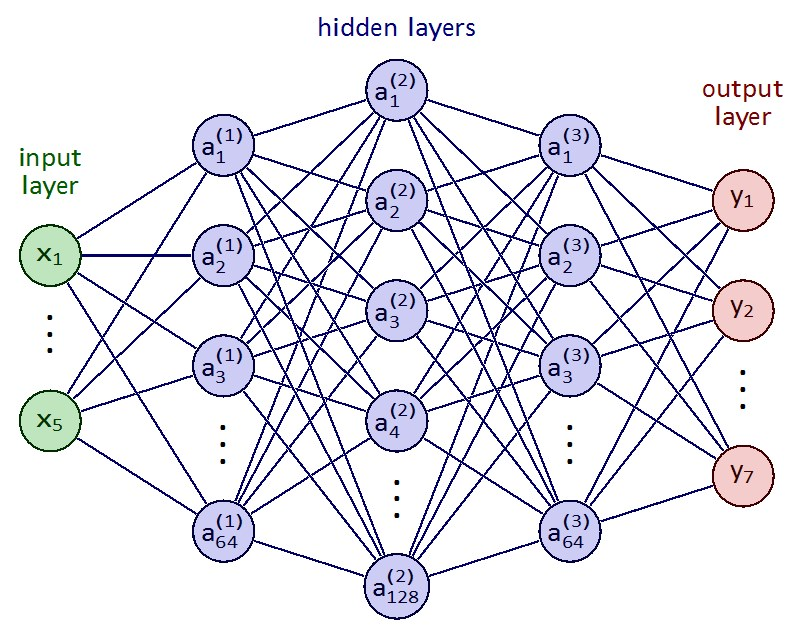

In [ ]:
def create_model_R5():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(5,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(7)
  ])
  return model

def train_model_w_CV(model, X_train, y_train, param_grid, fold_num):
  scorer = make_scorer(mean_squared_error, greater_is_better=False)
  grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=fold_num, verbose=10)
  grid_result = grid.fit(X_train, y_train, verbose = 0)

  print("\n\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  return grid_result.best_estimator_

def evaluate_model_R5(model, X_test, y_test):
    predictions = model.predict(X_test)
    #MSE
    pos_error = np.mean(np.sum((predictions[:, :3] - y_test[:, :3])**2, axis=1))
    orient_error = np.mean(np.sum((predictions[:, 3:] - y_test[:, 3:])**2, axis=1))
    tot_error = mean_squared_error(y_test, predictions)
    print(f"Total Error: {tot_error:.6f}")
    print(f"Position Error (meters): {pos_error:.6f}")
    print(f"Orientation Error (quaternion): {orient_error:.6f}")
    return tot_error, pos_error, orient_error

In [ ]:
def plot_loss_curves_R5(history):
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Curves')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  #set y-axis limits
  y_min = min(min(history.history['loss']), min(history.history['val_loss']))
  y_max = max(max(history.history['loss']), max(history.history['val_loss']))
  plt.ylim(y_min, y_max)
  plt.show()

def plot_loss_train_val_R5(best_model, X_train, y_train, val_dim):
  X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=val_dim, random_state=42)

  best_lr = best_model.get_params()['optimizer__learning_rate']
  best_batch = best_model.get_params()['batch_size']
  best_epoch = best_model.get_params()['epochs']
  # print("Best learning rate:", best_lr)
  # print("Best batch size:", best_batch)
  # print("Best number of epochs:", best_epoch)

  fresh_model=create_model_R5()
  fresh_model.compile(loss='mse', optimizer=Adam(learning_rate=best_lr))
  history = fresh_model.fit(
              X_train, y_train,
              epochs = best_epoch,
              batch_size = best_batch,
              validation_split=0.2,
              verbose = 0
          )
  plot_loss_curves_R5(history)

def plot_true_vs_pred_positions_3d(model, y_test, strg, dim):
    predictions = model.predict(X_test)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    true_x = y_test[:, 0]
    true_y = y_test[:, 1]
    true_z = y_test[:, 2]
    pred_x = predictions[:, 0]
    pred_y = predictions[:, 1]
    pred_z = predictions[:, 2]
    ax.scatter(true_x, true_y, true_z, c='blue', label='True Position', alpha=0.6, s=dim)
    ax.scatter(pred_x, pred_y, pred_z, c='red', label='Predicted Position', alpha=0.6, s=dim)
    ax.set_xlabel('X-axis (ft_x)')
    ax.set_ylabel('Y-axis (ft_y)')
    ax.set_zlabel('Z-axis (ft_z)')
    plt.title('True vs. Predicted End-Effector Position in 3D, '+strg)
    plt.legend()
    plt.show()

Overview of the model

In [ ]:
model = create_model_R5()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,415 (68.03 KB)

 Trainable params: 17,415 (68.03 KB)

 Non-trainable params: 0 (0.00 B)

###1k samples

In [ ]:
data_path_train = "/content/drive/MyDrive/Dataset_HW_ML/R5/r5_333_100k.csv"
data_path_test  = "/content/drive/MyDrive/Dataset_HW_ML/R5/r5_666_100k.csv"

dataset_dim = 1000
test_dim = 0.3
norm = False
X_train, _, X_test, y_train, _, y_test = create_dataset_R5(data_path_train, data_path_test, dataset_dim, test_dim, norm)

model = KerasRegressor(
    model=create_model_R5,
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

param_grid_R5 = {
    'epochs': [250, 500],
    'batch_size': [16, 32, 64],
    'optimizer__learning_rate': [0.01, 0.001, 0.0001]
}

num_folds = 5
best_model_R5_1k = train_model_w_CV(model, X_train, y_train, param_grid_R5, num_folds)
best_model_R5_1k.model_.save_weights('pesi_mod_R5_1k.weights.h5')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START batch_size=16, epochs=250, optimizer__learning_rate=0.01...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[CV 1/5; 1/18] END batch_size=16, epochs=250, optimizer__learning_rate=0.01;, score=-0.001 total time=  33.0s
[CV 2/5; 1/18] START batch_size=16, epochs=250, optimizer__learning_rate=0.01...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[CV 2/5; 1/18] END batch_size=16, epochs=250, optimizer__learning_rate=0.01;, score=-0.002 total time=  32.2s
[CV 3/5; 1/18] START batch_size=16, epochs=250, optimizer__learning_rate=0.01...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[CV 3/5; 1/18] END batch_size=16, epochs=250, optimizer__learning_rate=0.01;, score=-0.001 total time=  30.5s
[CV 4/5; 1/18] START batch_size=16, epochs=250, optimizer__learning_rate=0.01...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[CV 4/5; 1/18] END batch_size=16, epochs=250, optimizer__learning_rate=0.01;, score=-0.001 total time=  32.0s
[CV 5/5; 1/18] START batch_

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[CV 2/5; 7/18] END batch_size=32, epochs=250, optimizer__learning_rate=0.01;, score=-0.001 total time=  17.9s
[CV 3/5; 7/18] START batch_size=32, epochs=250, optimizer__learning_rate=0.01...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[CV 3/5; 7/18] END batch_size=32, epochs=250, optimizer__learning_rate=0.01;, score=-0.001 total time=  17.5s
[CV 4/5; 7/18] START batch_size=32, epochs=250, optimizer__learning_rate=0.01...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[CV 4/5; 7/18] END batch_size=32, epochs=250, optimizer__learning_rate=0.01;, score=-0.001 total time=  19.4s
[CV 5/5; 7/18] START batch_size=32, epochs=250, optimizer__learning_rate=0.01...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[CV 5/5; 7/18] END batch_size=32, epochs=250, optimizer__learning_rate=0.01;, score=-0.001 total time=  17.6s
[CV 1/5; 8/18] START batch_size=32, epochs=250, optimizer__learning_rate=0.001..
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[CV 1/5; 8/18] END batch_size=32, epochs=250, 

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,




Best: -0.000282 using {'batch_size': 16, 'epochs': 500, 'optimizer__learning_rate': 0.001}


Evaluation of the results

In [ ]:
tot_error, pos_error, orient_error = evaluate_model_R5(best_model_R5_1k, X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Total Error: 0.000185
Position Error (meters): 0.000459
Orientation Error (quaternion): 0.000833


Plot the loss curves <train, val> of the model, using 1k samples

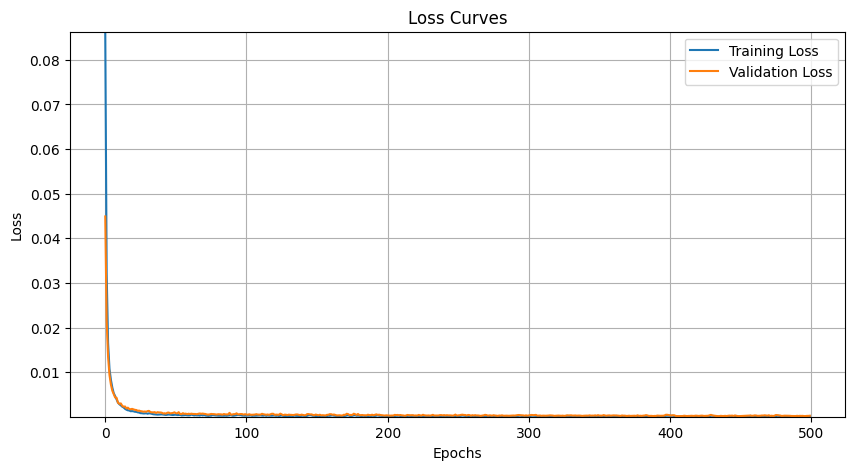

In [ ]:
val_dim = 0.2
plot_loss_train_val_R5(best_model_R5_1k, X_train, y_train, val_dim)

Comparison between predicted position and true positions

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


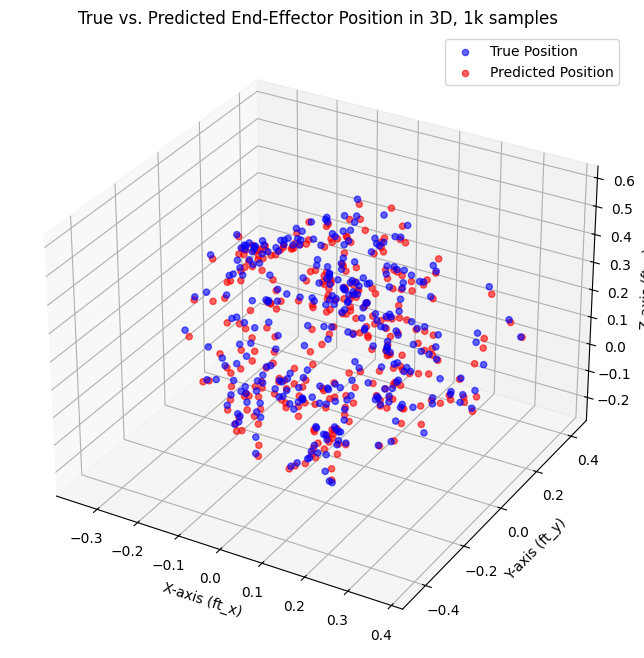

In [ ]:
strg = "1k samples"
plot_true_vs_pred_positions_3d(best_model_R5_1k, y_test, strg, 20)

###100k samples

In [ ]:
data_path_train = "/content/drive/MyDrive/Dataset_HW_ML/R5/r5_333_100k.csv"
data_path_test  = "/content/drive/MyDrive/Dataset_HW_ML/R5/r5_666_100k.csv"

dataset_dim = 100000
test_dim = 0.3
X_train, _, X_test, y_train, _, y_test = create_dataset_R5(data_path_train, data_path_test, dataset_dim, test_dim, False)

model = KerasRegressor(
    model=create_model_R5,
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

param_grid_R5 = {
    'epochs': [100],
    'batch_size': [16, 32],
    'optimizer__learning_rate': [0.001, 0.0001]
}

num_folds = 5
best_model_R5_100k = train_model_w_CV(model, X_train, y_train, param_grid_R5, num_folds)
best_model_R5_100k.model_.save_weights('pesi_mod_R5_100k.weights.h5')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START batch_size=16, epochs=100, optimizer__learning_rate=0.001...
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[CV 1/5; 1/4] END batch_size=16, epochs=100, optimizer__learning_rate=0.001;, score=-0.000 total time=10.6min
[CV 2/5; 1/4] START batch_size=16, epochs=100, optimizer__learning_rate=0.001...
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[CV 2/5; 1/4] END batch_size=16, epochs=100, optimizer__learning_rate=0.001;, score=-0.000 total time=11.2min
[CV 3/5; 1/4] START batch_size=16, epochs=100, optimizer__learning_rate=0.001...
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[CV 3/5; 1/4] END batch_size=16, epochs=100, optimizer__learning_rate=0.001;, score=-0.000 total time=11.3min
[CV 4/5; 1/4] START batch_size=16, epochs=100, optimizer__learning_rate=0.001...
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[CV 4/5; 1/4] END batch_size=16, epochs=100, optimizer__learning_rate=0.001;, score=-0.000 total time=11.0min
[CV 5/5; 1/4

Evaluation of results

In [ ]:
tot_error, pos_error, orient_error = evaluate_model_R5(best_model_R5_100k, X_test, y_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Total Error: 0.000028
Position Error (meters): 0.000084
Orientation Error (quaternion): 0.000113


Plot the loss curves <train, val> of the model, using 100k samples

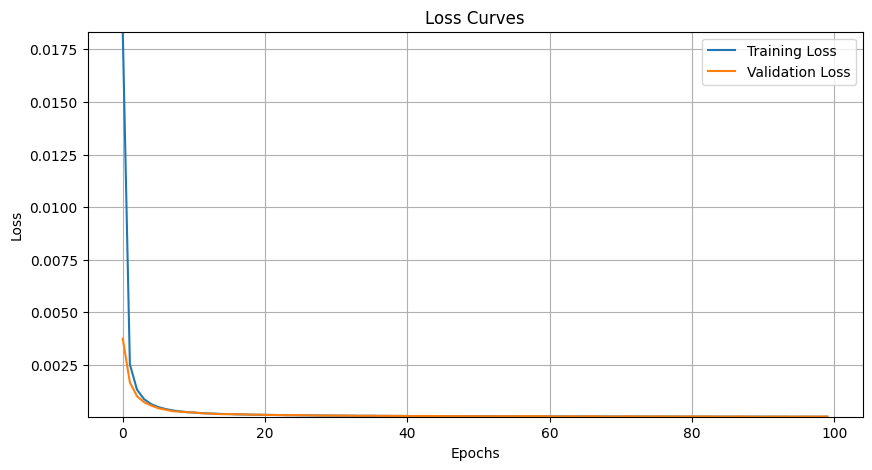

In [ ]:
val_dim = 0.2
plot_loss_train_val_R5(best_model_R5_100k, X_train, y_train, val_dim)

Comparison between predicted position and true positions

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


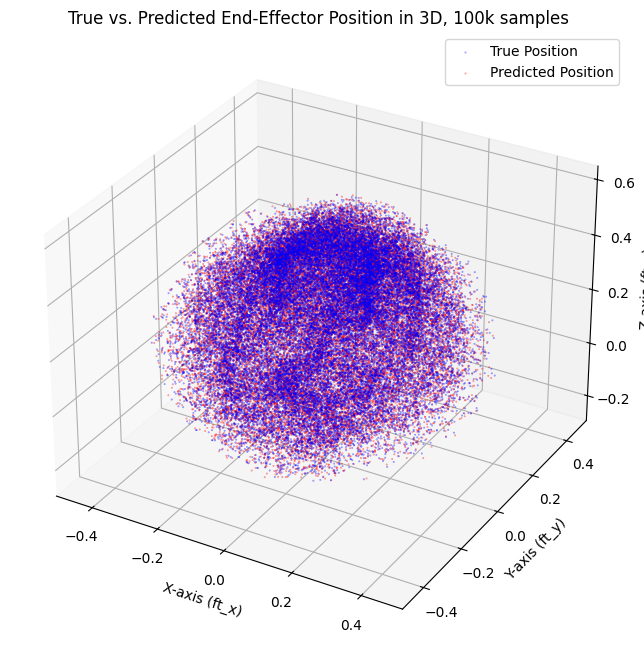

In [ ]:
strg = "100k samples"
plot_true_vs_pred_positions_3d(best_model_R5_100k, y_test, strg, 0.1)

###Jacobian computation, comparison

In [ ]:
@tf.function
def FK_Jacobian_R5(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK_5in_4out(model, x)
    return tape.jacobian(y, x)

def FK_5in_4out(model, theta):
    t = tf.reshape(theta, shape=(1,5))
    out = model.model_(t)
    out = tf.reshape(out, shape=(7,))
    return out

def analytical_Jacobian_R5(joint_angles):
    q1, q2, q3, q4, q5 = joint_angles
    L1, L2, L3, L4, L5 = 0.1, 0.1, 0.1, 0.1, 0.1

    J = np.zeros((3, 5))

    J[0, 0] = -math.sin(q1) * (L5 * math.cos(q2 + q3 + q4 + q5) + L3 * math.cos(q2 + q3) + L2 * math.cos(q2) + L4 * math.cos(q2 + q3 + q4))
    J[0, 1] = -math.cos(q1) * (L5 * math.sin(q2 + q3 + q4 + q5) + L3 * math.sin(q2 + q3) + L2 * math.sin(q2) + L4 * math.sin(q2 + q3 + q4))
    J[0, 2] = -math.cos(q1) * (L5 * math.sin(q2 + q3 + q4 + q5) + L3 * math.sin(q2 + q3) + L4 * math.sin(q2 + q3 + q4))
    J[0, 3] = -math.cos(q1) * (L5 * math.sin(q2 + q3 + q4 + q5) + L4 * math.sin(q2 + q3 + q4))
    J[0, 4] = -L5 * math.sin(q2 + q3 + q4 + q5) * math.cos(q1)

    J[1, 0] = math.cos(q1) * (L5 * math.cos(q2 + q3 + q4 + q5) + L3 * math.cos(q2 + q3) + L2 * math.cos(q2) + L4 * math.cos(q2 + q3 + q4))
    J[1, 1] = -math.sin(q1) * (L5 * math.sin(q2 + q3 + q4 + q5) + L3 * math.sin(q2 + q3) + L2 * math.sin(q2) + L4 * math.sin(q2 + q3 + q4))
    J[1, 2] = -math.sin(q1) * (L5 * math.sin(q2 + q3 + q4 + q5) + L3 * math.sin(q2 + q3) + L4 * math.sin(q2 + q3 + q4))
    J[1, 3] = -math.sin(q1) * (L5 * math.sin(q2 + q3 + q4 + q5) + L4 * math.sin(q2 + q3 + q4))
    J[1, 4] = -L5 * math.sin(q2 + q3 + q4 + q5) * math.sin(q1)

    J[2, 0] = 0
    J[2, 1] = L5 * math.cos(q2 + q3 + q4 + q5) + L3 * math.cos(q2 + q3) + L2 * math.cos(q2) + L4 * math.cos(q2 + q3 + q4)
    J[2, 2] = L5 * math.cos(q2 + q3 + q4 + q5) + L3 * math.cos(q2 + q3) + L4 * math.cos(q2 + q3 + q4)
    J[2, 3] = L5 * math.cos(q2 + q3 + q4 + q5) + L4 * math.cos(q2 + q3 + q4)
    J[2, 4] = L5 * math.cos(q2 + q3 + q4 + q5)

    return J

def comparison_R5(X_test, model, comparison_num, verbose):
  frobenius_distances = []

  random_indices = random.sample(range(len(X_test)), comparison_num)
  for index in random_indices:
      x = X_test[index]
      j0_j5 = x[:5] #model has 5 features
      t = tf.constant(j0_j5, dtype=tf.float32)

      J_learned = FK_Jacobian_R5(model, t)
      J_learned_position = J_learned.numpy()[:3, :]  # Take only the first 3 rows, position

      joint_angles = j0_j5
      J_analytical = analytical_Jacobian_R5(joint_angles)

      frb_dist = similarity_score(J_learned_position, J_analytical)
      frobenius_distances.append(frb_dist)

      if verbose:
        print("Learned Jacobian position:")
        print(J_learned_position)
        print("\nAnalytical Jacobian position:")
        print(J_analytical)

  print(f"Mean Frobenius Distance: {np.mean(frobenius_distances):.6f}")
  print(f"Frobenius Distance StdDev: {np.std(frobenius_distances):.6f}")

####Model trained on 1k

In [ ]:
num_of_comparison = 50
verbose = False
comparison_R5(X_test, best_model_R5_1k, num_of_comparison, verbose)

Mean Frobenius Distance: 0.531923
Frobenius Distance StdDev: 0.132849


####Model trained on 100k

In [ ]:
num_of_comparison = 50
verbose = False
comparison_R5(X_test, best_model_R5_100k, num_of_comparison, verbose)

Mean Frobenius Distance: 0.492613
Frobenius Distance StdDev: 0.107868
